In [32]:
# Univariate Load Forecasting (ERCOT Only)
# Forecast next 2 hours based solely on historical ERCOT load

import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional, SimpleRNN
from keras.callbacks import EarlyStopping
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Parameters
window = 24
horizon = 2
batch_size = 64
epochs = 100

# Load dataset
df = pd.read_excel("ercot_cleaned.xlsx")

# add datetime features
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

# Add useful time features
df["hour"] = df.index.hour
df["day"] = df.index.day
df["month"] = df.index.month
df["dayofweek"] = df.index.dayofweek
df["sin_hour"] = np.sin(2 * np.pi * df.index.hour / 24)
df["cos_hour"] = np.cos(2 * np.pi * df.index.hour / 24)

# Only select ERCOT column (UNIVARIATE model)
target_col = 'ercot'
data = df[[target_col]]

# ============================================================
# SCALE WITHOUT DATA LEAKAGE: SPLIT FIRST, THEN FIT SCALER
# ============================================================

# Time-based split index (80% train, 20% test)
split_idx = int(0.8 * len(data))
train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]

# Fit scaler ONLY on training data
scaler = MinMaxScaler()
scaler.fit(train_data)

# Transform both train and test using the same scaler
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

# DataFrames for convenience
train_scaled_df = pd.DataFrame(train_scaled, index=train_data.index, columns=[target_col])
test_scaled_df = pd.DataFrame(test_scaled, index=test_data.index, columns=[target_col])

# Also build a full scaled_df (train+test) for forecasting later
scaled_full = np.vstack([train_scaled, test_scaled])
scaled_df = pd.DataFrame(scaled_full, index=data.index, columns=[target_col])

# ============================================================
# Create sliding windows (train and test separately)
# ============================================================

def make_windows_univariate(series, window, horizon):
    X, y = [], []
    arr = series.values
    for i in range(len(arr) - window - horizon):
        X.append(arr[i:i+window])
        y.append(arr[i+window:i+window+horizon])
    return np.array(X), np.array(y)

# Windows for train and test
X_train, y_train = make_windows_univariate(train_scaled_df, window, horizon)
X_test, y_test = make_windows_univariate(test_scaled_df, window, horizon)

# reshape X to (samples, window, 1)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# reshape y to (samples, horizon)
y_train = y_train.reshape(y_train.shape[0], horizon)
y_test = y_test.reshape(y_test.shape[0], horizon)

In [28]:
# ============================================================
# Build Vanilla RNN Model (Univariate)
# ============================================================

model = Sequential()
model.add(SimpleRNN(64, return_sequences=True, input_shape=(window, 1)))
model.add(Dropout(0.3))
model.add(SimpleRNN(32))
model.add(Dense(32, activation='relu'))
model.add(Dense(horizon))  # predicting next 2 hours

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Early stopping
es = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train Model
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[es],
    verbose=1
)




Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


630/630 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.0106 - mae: 0.0610 - val_loss: 0.0012 - val_mae: 0.0285
Epoch 2/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 9.8541e-04 - mae: 0.0242 - val_loss: 5.4207e-04 - val_mae: 0.0181
Epoch 3/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 7.6928e-04 - mae: 0.0214 - val_loss: 8.0846e-04 - val_mae: 0.0224
Epoch 4/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 6.1402e-04 - mae: 0.0190 - val_loss: 3.6218e-04 - val_mae: 0.0148
Epoch 5/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 5.5920e-04 - mae: 0.0181 - val_loss: 2.9329e-04 - val_mae: 0.0127
Epoch 6/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 5.2979e-04 - mae: 0.0176 - val_loss: 3.0667e-04 - val_mae: 0.0131
Epoch 7/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 5.1011e-04 - mae: 0.0168 - val_loss: 3.6423e-04 - val_mae: 0.0146
Epoch 8/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 5.1168e-04 - mae: 0.0173 - val_loss: 5.7352e-04 - val_

Training Loss: [0.0035560408141463995, 0.0009086772333830595, 0.0007038897019810975, 0.0006077163852751255, 0.0005691834376193583, 0.0005298670148476958, 0.0005929137696512043, 0.0004943087114952505, 0.00043429137440398335, 0.000408918276662007, 0.0004361705214250833, 0.0003834251838270575, 0.0003860789001919329, 0.00036121776793152094, 0.0003512593393679708, 0.0003374436346348375, 0.0003254386247135699, 0.0003360033151693642, 0.00032653554808348417, 0.00031626655254513025, 0.0002991574874613434]
Training MAE: [0.03804229199886322, 0.02323581650853157, 0.0203668512403965, 0.01889035291969776, 0.018175959587097168, 0.017587171867489815, 0.017963029444217682, 0.016901828348636627, 0.0157597828656435, 0.01528838835656643, 0.015815267339348793, 0.014756121672689915, 0.014829756692051888, 0.014384625479578972, 0.014181546866893768, 0.013874820433557034, 0.013610233552753925, 0.013823239132761955, 0.01361104566603899, 0.013420969247817993, 0.013059472665190697]


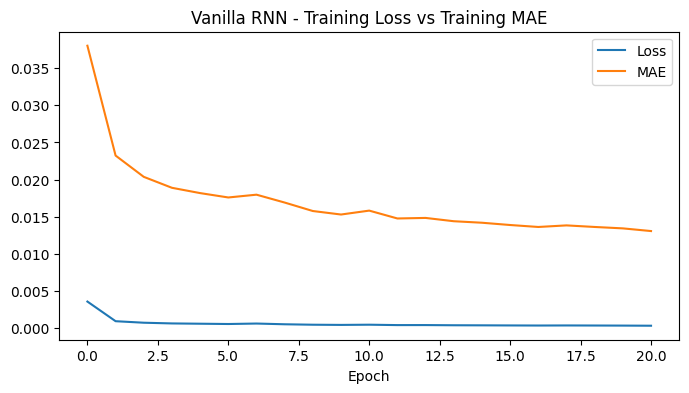

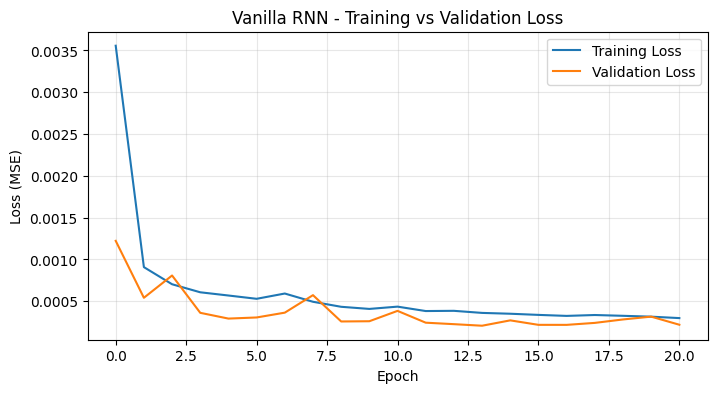

315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

Vanilla RNN - Overall Evaluation (Original Scale - MW)
MSE : 698899.1941838886
RMSE: 836.0019103948798
MAE : 611.5780302760593
MAPE: 1.1092190220260474 %


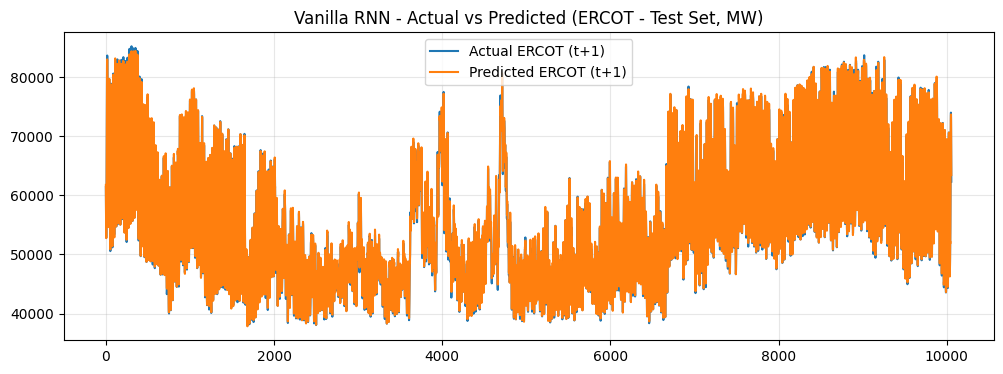

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


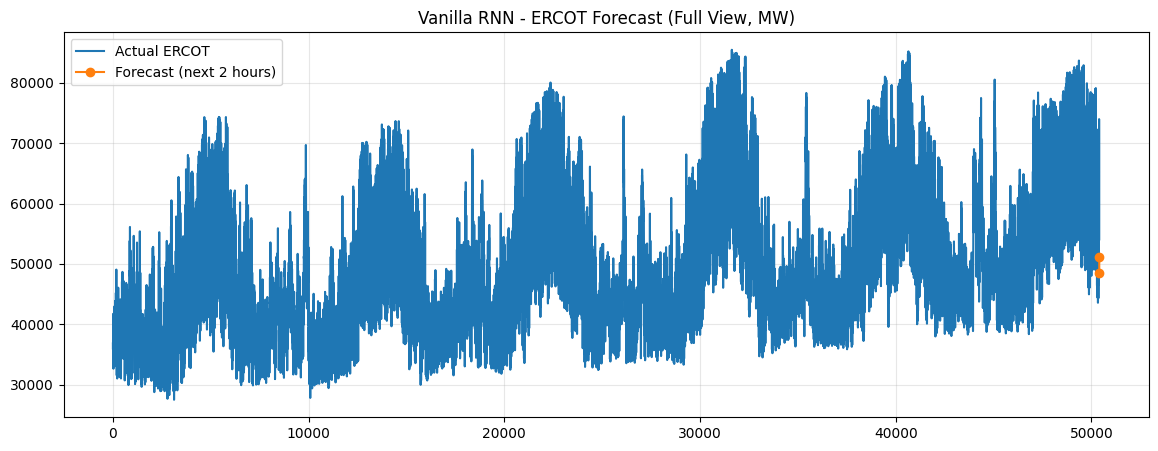

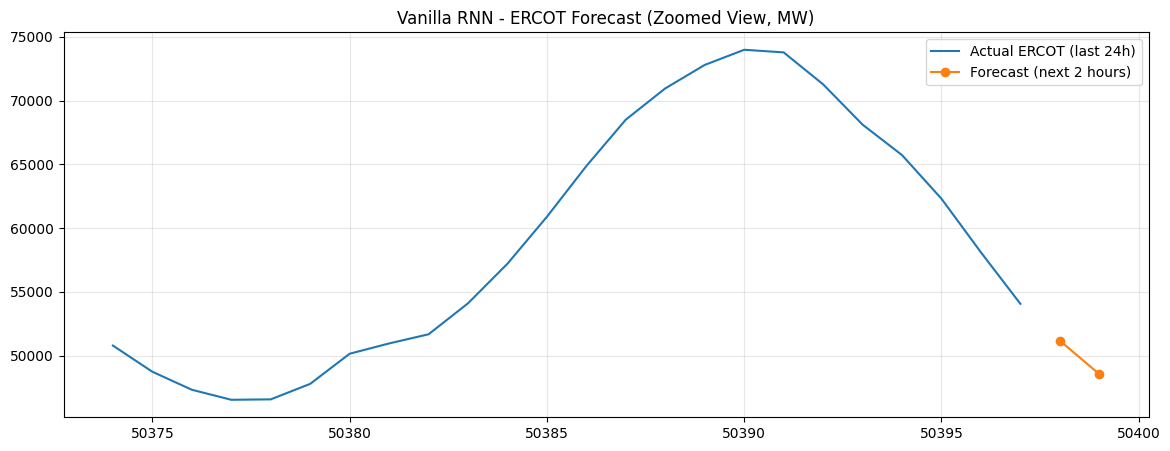

In [29]:
# Vanilla RNN Evaluation
# Show training results
print("Training Loss:", history.history['loss'])
print("Training MAE:", history.history['mae'])

# PLOT 1: Loss vs MAE
pyplot.figure(figsize=(8,4))
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['mae'])
pyplot.title('Vanilla RNN - Training Loss vs Training MAE')
pyplot.xlabel('Epoch')
pyplot.legend(['Loss', 'MAE'], loc='upper right')
pyplot.show()

# =============================================
# PLOT: Training Loss vs Validation Loss
# =============================================

pyplot.figure(figsize=(8,4))
pyplot.plot(history.history['loss'], label='Training Loss')
pyplot.plot(history.history['val_loss'], label='Validation Loss')
pyplot.title('Vanilla RNN - Training vs Validation Loss')
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss (MSE)')
pyplot.legend()
pyplot.grid(True, alpha=0.3)
pyplot.show()
# ==========================
# PREDICT & INVERSE TRANSFORM
# ==========================

# Predict on test set (still scaled)
y_pred_scaled = model.predict(X_test)          # shape: (n_samples, horizon)
y_true_scaled = y_test                         # shape: (n_samples, horizon)

# Flatten to 1D, because scaler expects 2D (n_samples, n_features=1)
y_pred_flat_scaled = y_pred_scaled.flatten().reshape(-1, 1)
y_true_flat_scaled = y_true_scaled.flatten().reshape(-1, 1)

# Inverse transform back to original MW units
y_pred_flat = scaler.inverse_transform(y_pred_flat_scaled).flatten()
y_true_flat = scaler.inverse_transform(y_true_flat_scaled).flatten()

# Reshape back to (n_samples, horizon) for convenience
y_pred = y_pred_flat.reshape(-1, horizon)
y_true = y_true_flat.reshape(-1, horizon)

# ==========================
# EVALUATION METRICS (ORIGINAL SCALE-MW)
# ==========================
mse = mean_squared_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_flat, y_pred_flat)

eps = 1e-8
mape = np.mean(np.abs((y_true_flat - y_pred_flat) / (y_true_flat + eps))) * 100

print("\nVanilla RNN - Overall Evaluation (Original Scale - MW)")
print("MSE :", mse)
print("RMSE:", rmse)
print("MAE :", mae)
print("MAPE:", mape, "%")


# ==========================
# PLOT 2: ACTUAL vs PREDICTED (ORIGINAL SCALE)
# ==========================

actual_test = y_true[:, 0]
pred_test = y_pred[:, 0]

pyplot.figure(figsize=(12, 4))
pyplot.plot(actual_test, label='Actual ERCOT (t+1)')
pyplot.plot(pred_test, label='Predicted ERCOT (t+1)')
pyplot.title("Vanilla RNN - Actual vs Predicted (ERCOT - Test Set, MW)")
pyplot.grid(True, alpha=0.3)
pyplot.legend()
pyplot.show()

# ==========================
# FORECAST NEXT 2 HOURS (INVERSE TRANSFORM)
# ==========================

last_window_scaled = scaled_df[target_col].values[-window:].reshape(1, window, 1)

future_pred_scaled = model.predict(last_window_scaled).reshape(horizon, 1)
future_pred = scaler.inverse_transform(future_pred_scaled).flatten()

actual_series = df[target_col].values  # original MW
future_x = np.arange(len(actual_series), len(actual_series) + horizon)

pyplot.figure(figsize=(14, 5))
pyplot.title("Vanilla RNN - ERCOT Forecast (Full View, MW)")
pyplot.plot(np.arange(len(actual_series)), actual_series, label="Actual ERCOT")
pyplot.plot(future_x, future_pred, marker='o', label="Forecast (next 2 hours)")
pyplot.grid(True, alpha=0.3)
pyplot.legend()
pyplot.show()

zoom_window = 24
start = len(actual_series) - zoom_window

pyplot.figure(figsize=(14, 5))
pyplot.title("Vanilla RNN - ERCOT Forecast (Zoomed View, MW)")
pyplot.plot(
    np.arange(start, len(actual_series)),
    actual_series[start:],
    label="Actual ERCOT (last 24h)"
)
pyplot.plot(future_x, future_pred, marker='o', label="Forecast (next 2 hours)")
pyplot.grid(True, alpha=0.3)
pyplot.legend()
pyplot.show()


In [30]:
# ============================================================
# Build Unidirectional LSTM Model (Univariate)
# ============================================================

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(window, 1)))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dense(32, activation='relu'))
model.add(Dense(horizon))  # predicting next 2 hours

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Early stopping
es = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train Model
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[es],
    verbose=1
)



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - loss: 0.0163 - mae: 0.0853 - val_loss: 0.0022 - val_mae: 0.0366
Epoch 2/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - loss: 0.0019 - mae: 0.0338 - val_loss: 9.4874e-04 - val_mae: 0.0227
Epoch 3/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 0.0012 - mae: 0.0268 - val_loss: 7.0395e-04 - val_mae: 0.0200
Epoch 4/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - loss: 8.0584e-04 - mae: 0.0215 - val_loss: 4.8844e-04 - val_mae: 0.0166
Epoch 5/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - loss: 6.7457e-04 - mae: 0.0197 - val_loss: 3.9023e-04 - val_mae: 0.0145
Epoch 6/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - loss: 5.7714e-04 - mae: 0.0182 - val_loss: 4.4637e-04 - val_mae: 0.0165
Epoch 7/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - loss: 5.0048e-04 - mae: 0.0169 - val_loss: 4.1967e-04 - val_mae: 0.0159
Epoch 8/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - loss: 4.7842e-04 - mae: 0.0165 - val_loss: 3.4780e-04 - 

Training Loss: [0.006381721701472998, 0.0017335049342364073, 0.0010962571250274777, 0.0007606763974763453, 0.0006527638761326671, 0.000560196815058589, 0.0004928929847665131, 0.0004664407460950315, 0.0004490198043640703, 0.0004155555507168174, 0.0004002220812253654, 0.00036558439023792744, 0.00034766155295073986, 0.0003292030014563352, 0.0003149277763441205, 0.00030849387985654175, 0.0003026418562512845, 0.0002963283914141357, 0.00028081779601052403, 0.00028414922417141497, 0.00027574755949899554, 0.00026576139498502016, 0.0002637795696500689, 0.00025492606800980866, 0.0002476284862495959, 0.00024750601733103395, 0.0002420214586891234, 0.00023683514154981822, 0.0002345355023862794, 0.00022275499941315502, 0.00022026096121408045, 0.00021651561837643385, 0.00021396501688286662, 0.00020779545593541116, 0.00020590210624504834, 0.00020506567670963705, 0.00020083283015992492, 0.000196982262423262, 0.00019709639309439808, 0.00019623132538981736, 0.00019033935677725822, 0.00018981652101501822,

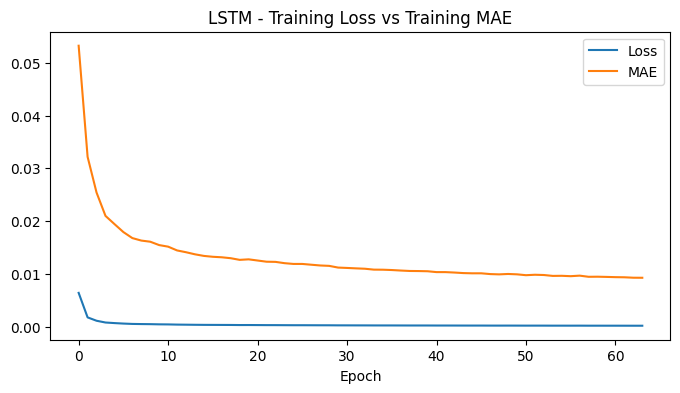

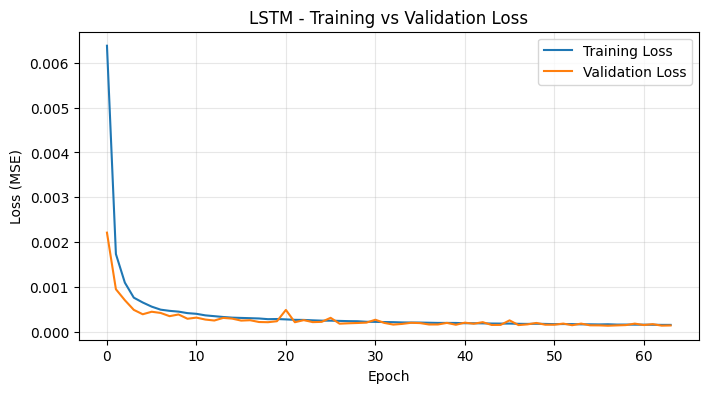

315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step

LSTM - Overall Evaluation (Original Scale - MW)
MSE : 452321.16416799405
RMSE: 672.5482615901955
MAE : 491.6869811511463
MAPE: 0.8856127595613099 %


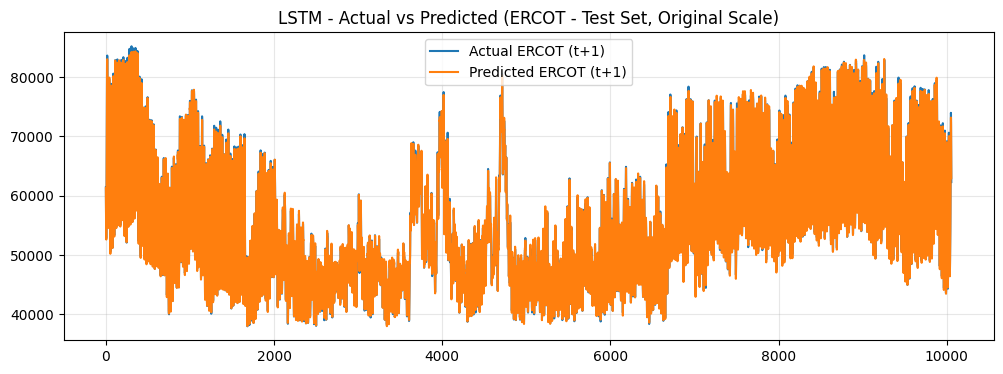

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


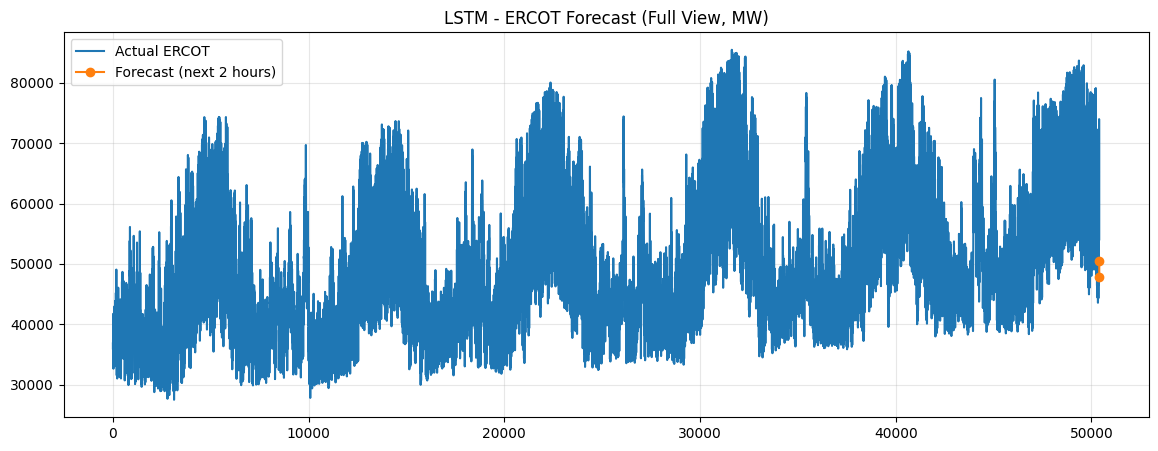

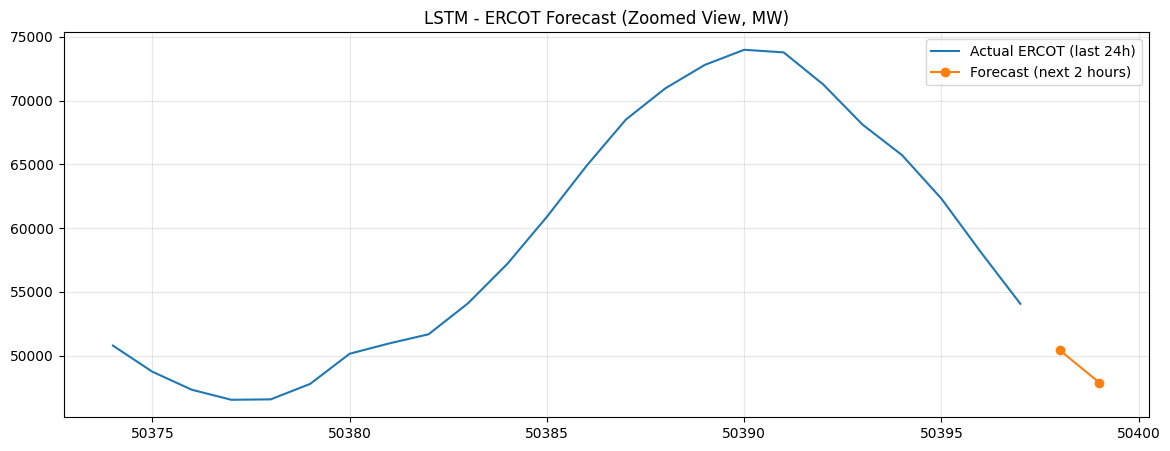

In [31]:
#LSTM - Evaluation
# Show training results
print("Training Loss:", history.history['loss'])
print("Training MAE:", history.history['mae'])

# PLOT 1: Loss vs MAE
pyplot.figure(figsize=(8,4))
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['mae'])
pyplot.title('LSTM - Training Loss vs Training MAE')
pyplot.xlabel('Epoch')
pyplot.legend(['Loss', 'MAE'], loc='upper right')
pyplot.show()

# =============================================
# PLOT: Training Loss vs Validation Loss
# =============================================

pyplot.figure(figsize=(8,4))
pyplot.plot(history.history['loss'], label='Training Loss')
pyplot.plot(history.history['val_loss'], label='Validation Loss')
pyplot.title('LSTM - Training vs Validation Loss')
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss (MSE)')
pyplot.legend()
pyplot.grid(True, alpha=0.3)
pyplot.show()

# ==========================
# PREDICT & INVERSE TRANSFORM
# ==========================

# Predict on test set (still scaled)
y_pred_scaled = model.predict(X_test)          # shape: (n_samples, horizon)
y_true_scaled = y_test                         # shape: (n_samples, horizon)

# Flatten to 1D, because scaler expects 2D (n_samples, n_features=1)
y_pred_flat_scaled = y_pred_scaled.flatten().reshape(-1, 1)
y_true_flat_scaled = y_true_scaled.flatten().reshape(-1, 1)

# Inverse transform back to original MW units
y_pred_flat = scaler.inverse_transform(y_pred_flat_scaled).flatten()
y_true_flat = scaler.inverse_transform(y_true_flat_scaled).flatten()

# Reshape back to (n_samples, horizon) for convenience
y_pred = y_pred_flat.reshape(-1, horizon)
y_true = y_true_flat.reshape(-1, horizon)

# ==========================
# EVALUATION METRICS (ORIGINAL SCALE)
# ==========================
mse = mean_squared_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_flat, y_pred_flat)

eps = 1e-8
mape = np.mean(np.abs((y_true_flat - y_pred_flat) / (y_true_flat + eps))) * 100

print("\nLSTM - Overall Evaluation (Original Scale - MW)")
print("MSE :", mse)
print("RMSE:", rmse)
print("MAE :", mae)
print("MAPE:", mape, "%")



# ==========================
# PLOT 2: ACTUAL vs PREDICTED (ORIGINAL SCALE)
# ==========================

actual_test = y_true[:, 0]
pred_test = y_pred[:, 0]

pyplot.figure(figsize=(12, 4))
pyplot.plot(actual_test, label='Actual ERCOT (t+1)')
pyplot.plot(pred_test, label='Predicted ERCOT (t+1)')
pyplot.title("LSTM - Actual vs Predicted (ERCOT - Test Set, Original Scale)")
pyplot.grid(True, alpha=0.3)
pyplot.legend()
pyplot.show()

# ==========================
# FORECAST NEXT 2 HOURS (INVERSE TRANSFORM)
# ==========================

last_window_scaled = scaled_df[target_col].values[-window:].reshape(1, window, 1)

future_pred_scaled = model.predict(last_window_scaled).reshape(horizon, 1)
future_pred = scaler.inverse_transform(future_pred_scaled).flatten()

actual_series = df[target_col].values  # original MW
future_x = np.arange(len(actual_series), len(actual_series) + horizon)

pyplot.figure(figsize=(14, 5))
pyplot.title("LSTM - ERCOT Forecast (Full View, MW)")
pyplot.plot(np.arange(len(actual_series)), actual_series, label="Actual ERCOT")
pyplot.plot(future_x, future_pred, marker='o', label="Forecast (next 2 hours)")
pyplot.grid(True, alpha=0.3)
pyplot.legend()
pyplot.show()

zoom_window = 24
start = len(actual_series) - zoom_window

pyplot.figure(figsize=(14, 5))
pyplot.title("LSTM - ERCOT Forecast (Zoomed View, MW)")
pyplot.plot(
    np.arange(start, len(actual_series)),
    actual_series[start:],
    label="Actual ERCOT (last 24h)"
)
pyplot.plot(future_x, future_pred, marker='o', label="Forecast (next 2 hours)")
pyplot.grid(True, alpha=0.3)
pyplot.legend()
pyplot.show()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 46s 60ms/step - loss: 0.0126 - mae: 0.0666 - val_loss: 0.0012 - val_mae: 0.0258
Epoch 2/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - loss: 0.0013 - mae: 0.0273 - val_loss: 8.9163e-04 - val_mae: 0.0220
Epoch 3/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 37s 58ms/step - loss: 8.8963e-04 - mae: 0.0225 - val_loss: 5.4054e-04 - val_mae: 0.0174
Epoch 4/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - loss: 6.0261e-04 - mae: 0.0187 - val_loss: 5.2344e-04 - val_mae: 0.0173
Epoch 5/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 37s 58ms/step - loss: 5.4856e-04 - mae: 0.0179 - val_loss: 4.7481e-04 - val_mae: 0.0161
Epoch 6/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - loss: 4.9230e-04 - mae: 0.0168 - val_loss: 4.0771e-04 - val_mae: 0.0149
Epoch 7/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - loss: 4.7483e-04 - mae: 0.0165 - val_loss: 3.6400e-04 - val_mae: 0.0141
Epoch 8/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - loss: 4.2328e-04 - mae: 0.0156 - val_loss: 3.4659e-0

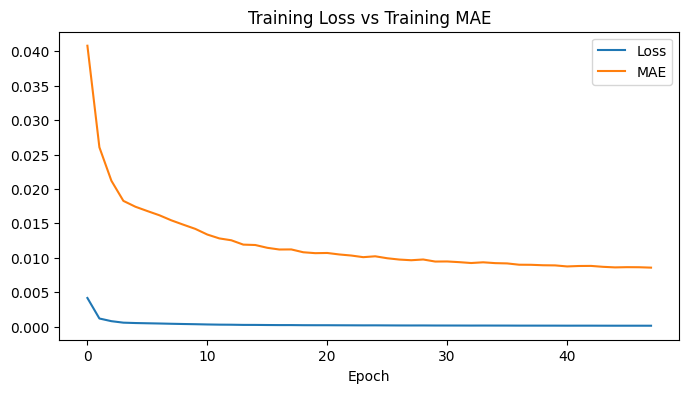

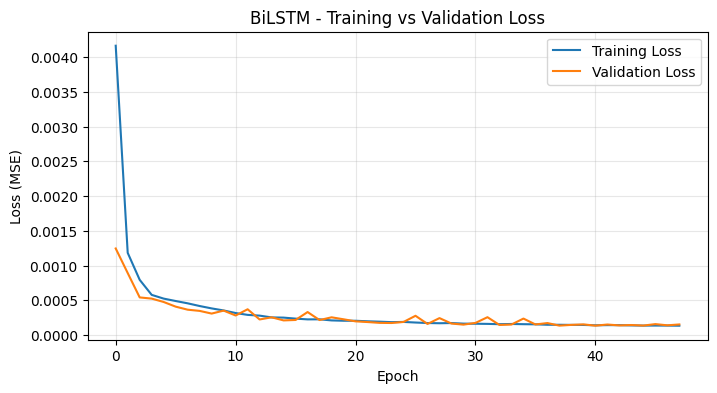

315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step

Overall Evaluation (Original Scale - MW)
MSE : 450374.84029809094
RMSE: 671.0997245552192
MAE : 477.74300044035954
MAPE: 0.859573626574046 %


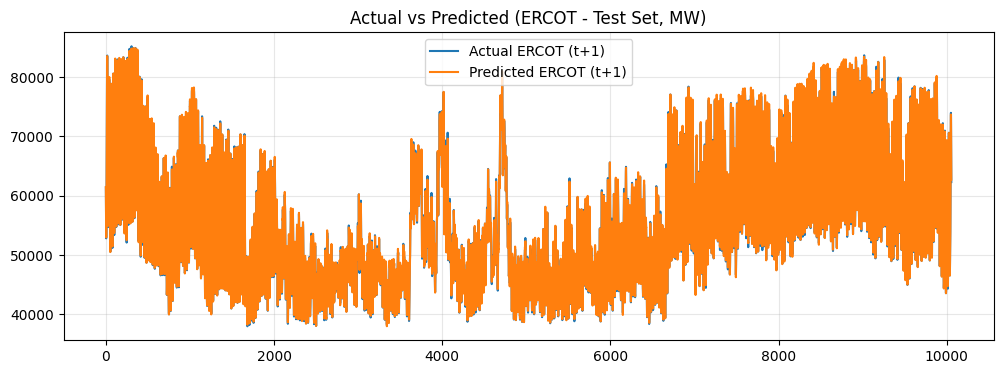

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


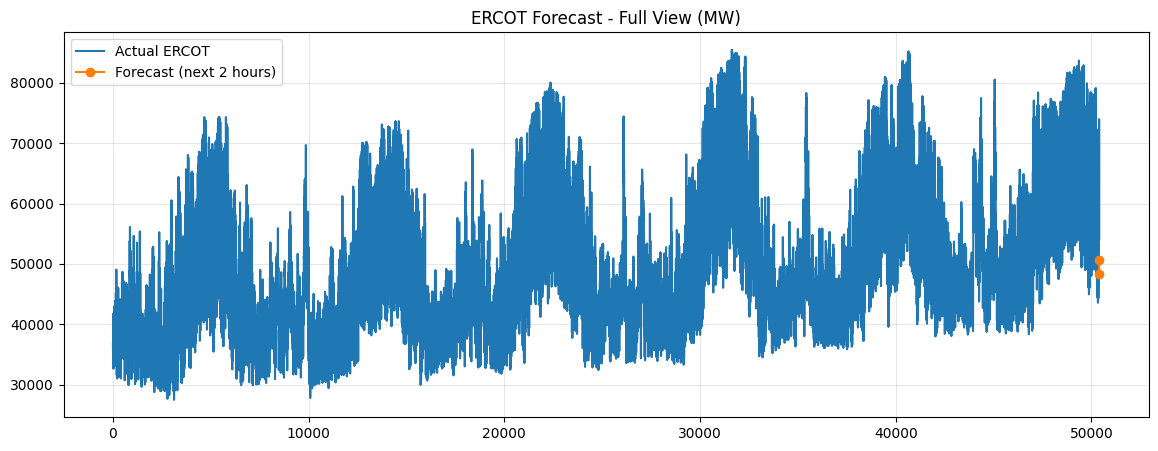

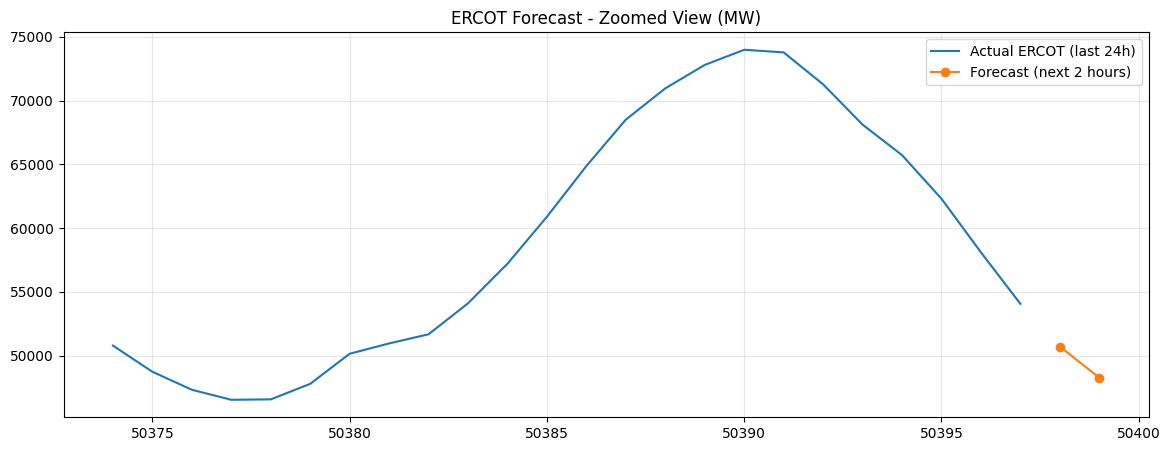

In [33]:
# ============================================================
# Build BiLSTM Model (Univariate)
# ============================================================

model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(window, 1)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32, activation='relu'))
model.add(Dense(horizon))  # predicting next 2 hours

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Early stopping
es = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train Model
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[es],
    verbose=1
)

# Show training results
print("Training Loss:", history.history['loss'])
print("Training MAE:", history.history['mae'])

# PLOT 1: Loss vs MAE
pyplot.figure(figsize=(8,4))
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['mae'])
pyplot.title('Training Loss vs Training MAE')
pyplot.xlabel('Epoch')
pyplot.legend(['Loss', 'MAE'], loc='upper right')
pyplot.show()

# =============================================
# PLOT: Training Loss vs Validation Loss
# =============================================

pyplot.figure(figsize=(8,4))
pyplot.plot(history.history['loss'], label='Training Loss')
pyplot.plot(history.history['val_loss'], label='Validation Loss')
pyplot.title('BiLSTM - Training vs Validation Loss')
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss (MSE)')
pyplot.legend()
pyplot.grid(True, alpha=0.3)
pyplot.show()
# ==========================
# PREDICT & INVERSE TRANSFORM
# ==========================

# Predict on test set (still scaled)
y_pred_scaled = model.predict(X_test)          # shape: (n_samples, horizon)
y_true_scaled = y_test                         # shape: (n_samples, horizon)

# Flatten to 1D, because scaler expects 2D (n_samples, n_features=1)
y_pred_flat_scaled = y_pred_scaled.flatten().reshape(-1, 1)
y_true_flat_scaled = y_true_scaled.flatten().reshape(-1, 1)

# Inverse transform back to original MW units
y_pred_flat = scaler.inverse_transform(y_pred_flat_scaled).flatten()
y_true_flat = scaler.inverse_transform(y_true_flat_scaled).flatten()

# Reshape back to (n_samples, horizon) for convenience
y_pred = y_pred_flat.reshape(-1, horizon)
y_true = y_true_flat.reshape(-1, horizon)

# ==========================
# EVALUATION METRICS (ORIGINAL SCALE)
# ==========================
mse = mean_squared_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_flat, y_pred_flat)

# MAPE with small epsilon to avoid division by zero
eps = 1e-8
mape = np.mean(np.abs((y_true_flat - y_pred_flat) / (y_true_flat + eps))) * 100

print("\nOverall Evaluation (Original Scale - MW)")
print("MSE :", mse)
print("RMSE:", rmse)
print("MAE :", mae)
print("MAPE:", mape, "%")


# ==========================
# PLOT 2: ACTUAL vs PREDICTED (ORIGINAL SCALE)
# ==========================

# Compare only the first horizon step (t+1) for visualization
actual_test = y_true[:, 0]
pred_test = y_pred[:, 0]

pyplot.figure(figsize=(12, 4))
pyplot.plot(actual_test, label='Actual ERCOT (t+1)')
pyplot.plot(pred_test, label='Predicted ERCOT (t+1)')
pyplot.title("Actual vs Predicted (ERCOT - Test Set, MW)")
pyplot.grid(True, alpha=0.3)
pyplot.legend()
pyplot.show()

# ==========================
# FORECAST NEXT 2 HOURS (INVERSE TRANSFORM)
# ==========================

# Use the last window from the *whole* scaled_df (train+test), for forecasting
last_window_scaled = scaled_df[target_col].values[-window:].reshape(1, window, 1)

future_pred_scaled = model.predict(last_window_scaled).reshape(horizon, 1)
future_pred = scaler.inverse_transform(future_pred_scaled).flatten()

# Actual full series in original scale
actual_series = df[target_col].values  # original MW
future_x = np.arange(len(actual_series), len(actual_series) + horizon)

# PLOT 3: Full Forecast (Original Scale)
pyplot.figure(figsize=(14, 5))
pyplot.title("ERCOT Forecast - Full View (MW)")
pyplot.plot(np.arange(len(actual_series)), actual_series, label="Actual ERCOT")
pyplot.plot(future_x, future_pred, marker='o', label="Forecast (next 2 hours)")
pyplot.grid(True, alpha=0.3)
pyplot.legend()
pyplot.show()

# PLOT 4: Zoomed Forecast (Last 24 Hours + 2 Steps Ahead)
zoom_window = 24
start = len(actual_series) - zoom_window

pyplot.figure(figsize=(14, 5))
pyplot.title("ERCOT Forecast - Zoomed View (MW)")
pyplot.plot(
    np.arange(start, len(actual_series)),
    actual_series[start:],
    label="Actual ERCOT (last 24h)"
)
pyplot.plot(future_x, future_pred, marker='o', label="Forecast (next 2 hours)")
pyplot.grid(True, alpha=0.3)
pyplot.legend()
pyplot.show()


Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


630/630 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - loss: 0.0152 - mae: 0.0769 - val_loss: 7.1220e-04 - val_mae: 0.0206
Epoch 2/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - loss: 8.4326e-04 - mae: 0.0222 - val_loss: 5.7791e-04 - val_mae: 0.0181
Epoch 3/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - loss: 6.0865e-04 - mae: 0.0187 - val_loss: 5.3127e-04 - val_mae: 0.0182
Epoch 4/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - loss: 5.1343e-04 - mae: 0.0171 - val_loss: 8.4933e-04 - val_mae: 0.0242
Epoch 5/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - loss: 4.8381e-04 - mae: 0.0166 - val_loss: 4.5275e-04 - val_mae: 0.0158
Epoch 6/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - loss: 4.4018e-04 - mae: 0.0157 - val_loss: 3.3268e-04 - val_mae: 0.0132
Epoch 7/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - loss: 3.8866e-04 - mae: 0.0148 - val_loss: 3.3286e-04 - val_mae: 0.0139
Epoch 8/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - loss: 3.5134e-04 - mae: 0.0141 - val_loss: 2.3682e-04 - 

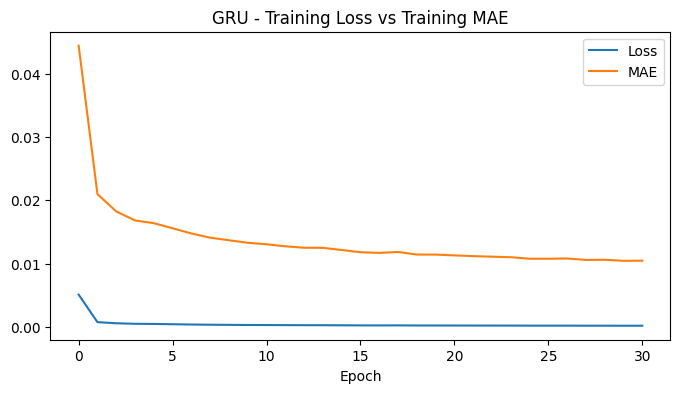

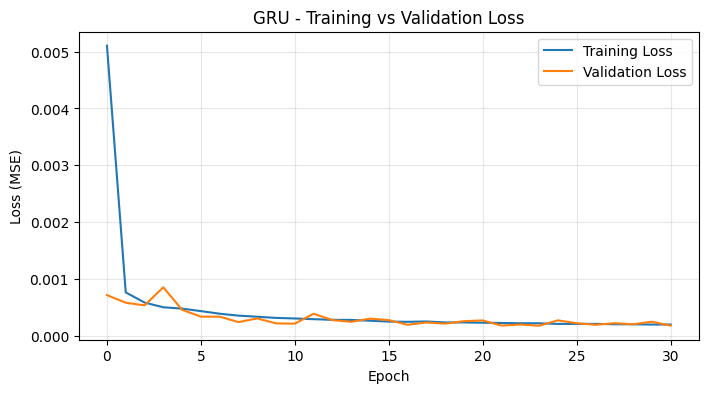

315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

GRU - Overall Evaluation (Original Scale - MW)
MSE : 581131.3235835945
RMSE: 762.3196990656837
MAE : 552.3716766258827
MAPE: 0.9970998988406581 %


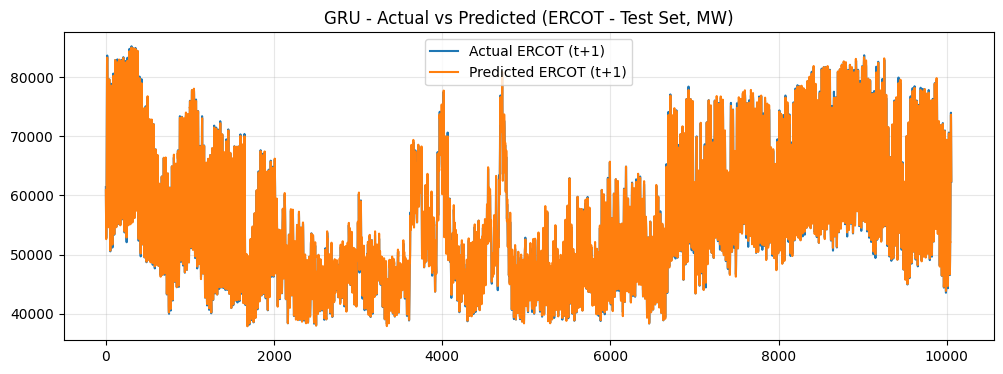

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


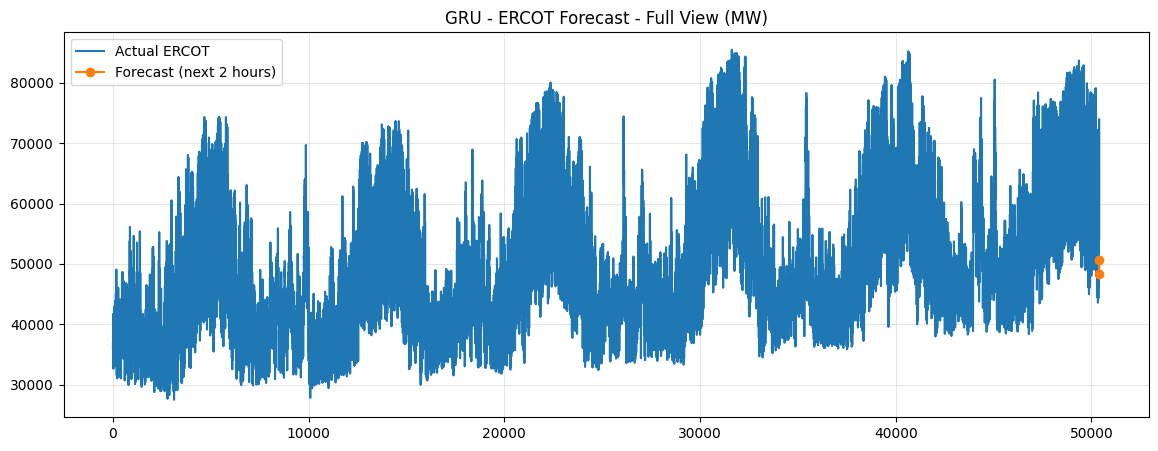

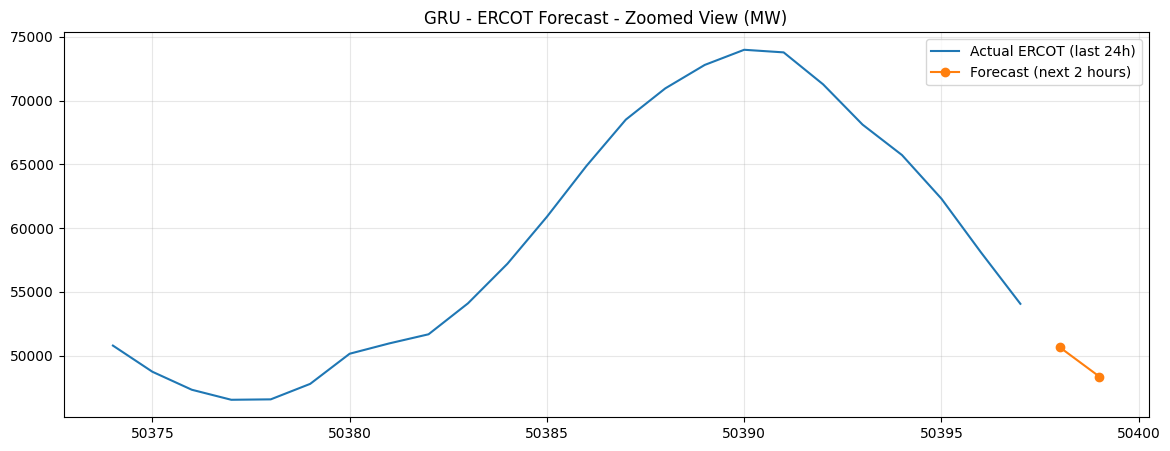

In [9]:
from keras.layers import GRU
# ============================================================
# Build GRU Model (Univariate)
# ============================================================

model = Sequential()
model.add(GRU(64, return_sequences=True, input_shape=(window, 1)))
model.add(Dropout(0.3))
model.add(GRU(32))
model.add(Dense(32, activation='relu'))
model.add(Dense(horizon))  # predicting next 2 hours

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Early stopping
es = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train Model
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[es],
    verbose=1
)

# Show training results
print("Training Loss:", history.history['loss'])
print("Training MAE:", history.history['mae'])

# PLOT 1: Loss vs MAE
pyplot.figure(figsize=(8,4))
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['mae'])
pyplot.title('GRU - Training Loss vs Training MAE')
pyplot.xlabel('Epoch')
pyplot.legend(['Loss', 'MAE'], loc='upper right')
pyplot.show()

# =============================================
# PLOT: Training Loss vs Validation Loss
# =============================================

pyplot.figure(figsize=(8,4))
pyplot.plot(history.history['loss'], label='Training Loss')
pyplot.plot(history.history['val_loss'], label='Validation Loss')
pyplot.title('GRU - Training vs Validation Loss')
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss (MSE)')
pyplot.legend()
pyplot.grid(True, alpha=0.3)
pyplot.show()

# ==========================
# PREDICT & INVERSE TRANSFORM
# ==========================

# Predict on test set (still scaled)
y_pred_scaled = model.predict(X_test)          # shape: (n_samples, horizon)
y_true_scaled = y_test                         # shape: (n_samples, horizon)

# Flatten to 1D, because scaler expects 2D (n_samples, n_features=1)
y_pred_flat_scaled = y_pred_scaled.flatten().reshape(-1, 1)
y_true_flat_scaled = y_true_scaled.flatten().reshape(-1, 1)

# Inverse transform back to original MW units
y_pred_flat = scaler.inverse_transform(y_pred_flat_scaled).flatten()
y_true_flat = scaler.inverse_transform(y_true_flat_scaled).flatten()

# Reshape back to (n_samples, horizon) for convenience
y_pred = y_pred_flat.reshape(-1, horizon)
y_true = y_true_flat.reshape(-1, horizon)

# ==========================
# EVALUATION METRICS (ORIGINAL SCALE)
# ==========================
mse = mean_squared_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_flat, y_pred_flat)

# MAPE with small epsilon to avoid division by zero
eps = 1e-8
mape = np.mean(np.abs((y_true_flat - y_pred_flat) / (y_true_flat + eps))) * 100

print("\nGRU - Overall Evaluation (Original Scale - MW)")
print("MSE :", mse)
print("RMSE:", rmse)
print("MAE :", mae)
print("MAPE:", mape, "%")

# ==========================
# PLOT 2: ACTUAL vs PREDICTED (ORIGINAL SCALE)
# ==========================

# Compare only the first horizon step (t+1) for visualization
actual_test = y_true[:, 0]
pred_test = y_pred[:, 0]

pyplot.figure(figsize=(12, 4))
pyplot.plot(actual_test, label='Actual ERCOT (t+1)')
pyplot.plot(pred_test, label='Predicted ERCOT (t+1)')
pyplot.title("GRU - Actual vs Predicted (ERCOT - Test Set, MW)")
pyplot.grid(True, alpha=0.3)
pyplot.legend()
pyplot.show()

# ==========================
# FORECAST NEXT 2 HOURS (INVERSE TRANSFORM)
# ==========================

# Use the last window from the *whole* scaled_df (train+test), for forecasting
last_window_scaled = scaled_df[target_col].values[-window:].reshape(1, window, 1)

future_pred_scaled = model.predict(last_window_scaled).reshape(horizon, 1)
future_pred = scaler.inverse_transform(future_pred_scaled).flatten()

# Actual full series in original scale
actual_series = df[target_col].values  # original MW
future_x = np.arange(len(actual_series), len(actual_series) + horizon)

# PLOT 3: Full Forecast (Original Scale)
pyplot.figure(figsize=(14, 5))
pyplot.title("GRU - ERCOT Forecast - Full View (MW)")
pyplot.plot(np.arange(len(actual_series)), actual_series, label="Actual ERCOT")
pyplot.plot(future_x, future_pred, marker='o', label="Forecast (next 2 hours)")
pyplot.grid(True, alpha=0.3)
pyplot.legend()
pyplot.show()

# PLOT 4: Zoomed Forecast (Last 24 Hours + 2 Steps Ahead)
zoom_window = 24
start = len(actual_series) - zoom_window

pyplot.figure(figsize=(14, 5))
pyplot.title("GRU - ERCOT Forecast - Zoomed View (MW)")
pyplot.plot(
    np.arange(start, len(actual_series)),
    actual_series[start:],
    label="Actual ERCOT (last 24h)"
)
pyplot.plot(future_x, future_pred, marker='o', label="Forecast (next 2 hours)")
pyplot.grid(True, alpha=0.3)
pyplot.legend()
pyplot.show()

In [1]:
#multivariate
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from keras.callbacks import EarlyStopping
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Parameters
window = 24
horizon = 2
batch_size = 64
epochs = 100

# 1. Load dataset
df = pd.read_excel("ercot_cleaned.xlsx")
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

# 2. ADD DATETIME FEATURES
df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["month"] = df.index.month

# 3. Select features
feature_cols = [
    'coast','east','fwest','north','ncent','south','scent','west','ercot',
    'hour','dayofweek','month'
]

data = df[feature_cols]

num_features = len(feature_cols)
num_outputs = 1    # <<< ONLY ERCOT is predicted
ercot_idx = data.columns.get_loc('ercot')  # index of 'ercot' column

# ------------------------------------------------------------
# 3.5 Train/Test SPLIT at DATA LEVEL (for scaling)
# ------------------------------------------------------------

split_idx_rows = int(0.8 * len(data))
train_data = data.iloc[:split_idx_rows]
test_data  = data.iloc[split_idx_rows:]

# ------------------------------------------------------------
# 4. Scaling - FIT ONLY ON TRAIN
# ------------------------------------------------------------

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data)     # fit on train
scaled_test  = scaler.transform(test_data)         # transform test

# Recombine to keep full time continuity for windowing
scaled = np.vstack([scaled_train, scaled_test])
scaled_df = pd.DataFrame(scaled, index=data.index, columns=data.columns)

# ------------------------------------------------------------
# 5. Create windows (multivariate X, univariate Y = ERCOT)
# ------------------------------------------------------------

def make_windows(df, window, horizon, target_col_idx):
    X, y = [], []
    arr = df.values
    for i in range(len(arr) - window - horizon):
        # past window of ALL features
        X.append(arr[i:i+window, :])
        # next horizon steps of ONLY target column (ercot)
        y.append(arr[i+window:i+window+horizon, target_col_idx])
    return np.array(X), np.array(y)

X, y = make_windows(scaled_df, window, horizon, ercot_idx)
# y shape: (samples, horizon)

# Train/test split at sample level
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [17]:
# Vanilla RNN - Multiple features
model = Sequential()
model.add(SimpleRNN(64, return_sequences=True, input_shape=(window, num_features)
))
model.add(Dropout(0.3))
model.add(SimpleRNN(32))
model.add(Dense(32, activation='relu'))
model.add(Dense(horizon))  # predicting next 2 hours

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Early stopping
es = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train Model
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[es],
    verbose=1
)


Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


630/630 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 0.0323 - mae: 0.1108 - val_loss: 0.0013 - val_mae: 0.0273
Epoch 2/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0017 - mae: 0.0319 - val_loss: 8.7284e-04 - val_mae: 0.0227
Epoch 3/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0012 - mae: 0.0271 - val_loss: 6.8863e-04 - val_mae: 0.0197
Epoch 4/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 9.7808e-04 - mae: 0.0242 - val_loss: 6.0426e-04 - val_mae: 0.0186
Epoch 5/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 8.7548e-04 - mae: 0.0230 - val_loss: 5.3332e-04 - val_mae: 0.0174
Epoch 6/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 8.3138e-04 - mae: 0.0224 - val_loss: 5.0262e-04 - val_mae: 0.0171
Epoch 7/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 6.8979e-04 - mae: 0.0203 - val_loss: 8.9421e-04 - val_mae: 0.0238
Epoch 8/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 6.2548e-04 - mae: 0.0194 - val_loss: 4.1008e-04 - val_mae: 0.0

Training Loss: [0.010396145284175873, 0.001536066411063075, 0.001154845580458641, 0.0009488394134677947, 0.000830012490041554, 0.0007889807457104325, 0.0006735185743309557, 0.0006281625828705728, 0.000573218276258558, 0.0005281107150949538, 0.000510015815962106, 0.000495768035762012, 0.0004656577075365931, 0.0004362061736173928, 0.00040822935989126563, 0.00038678967393934727, 0.0003538586606737226, 0.0003423308953642845, 0.0003509653906803578, 0.0003311604668851942, 0.00034333826624788344, 0.0003030162479262799, 0.00037544284714385867, 0.0003038803406525403, 0.00029223188175819814, 0.000289442075882107, 0.0002873672638088465, 0.00027090212097391486]
Training MAE: [0.06307122856378555, 0.030337385833263397, 0.026309698820114136, 0.02386692725121975, 0.02238340862095356, 0.021844632923603058, 0.02006656862795353, 0.01944529078900814, 0.018584420904517174, 0.01776701770722866, 0.017504099756479263, 0.017235733568668365, 0.016730336472392082, 0.01609966717660427, 0.015657315030694008, 0.01

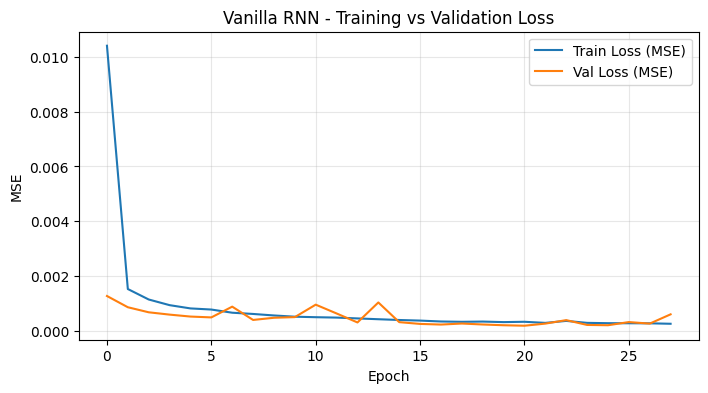

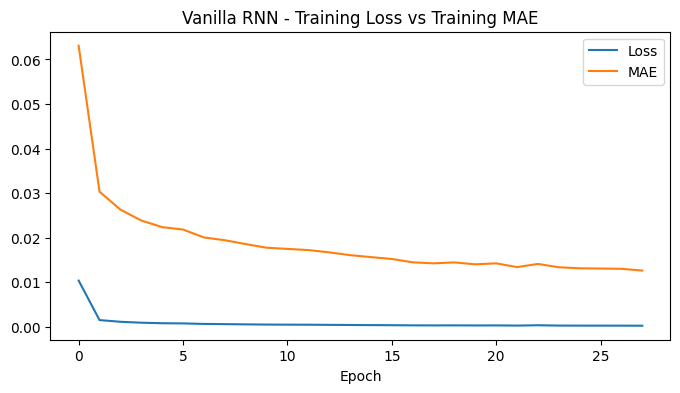

315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

 Overall Evaluation for ERCOT (Original Scale - MW)
MSE: 671341.2114207362
RMSE: 819.3541428593231
MAE: 606.8645166170351
MAPE: 1.102592405336074 %


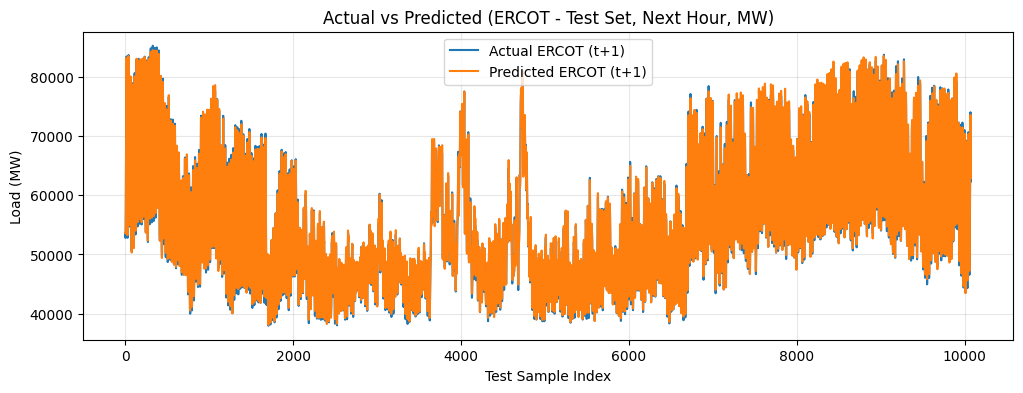

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


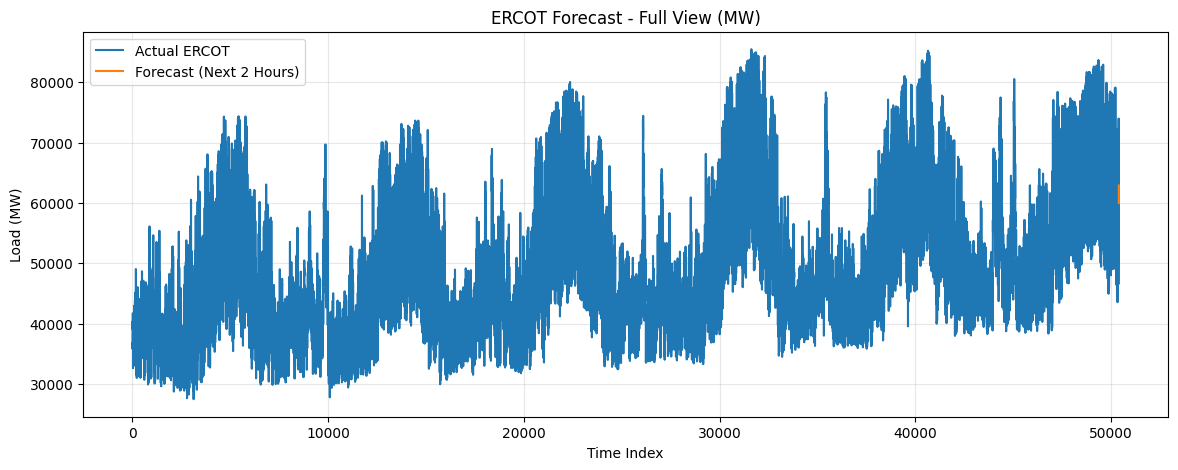

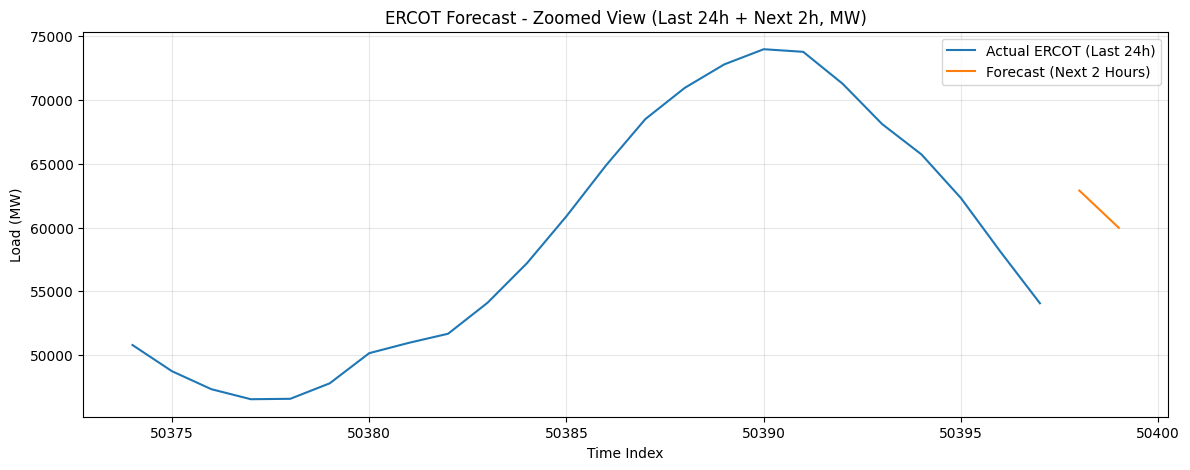

In [18]:
# Vanilla RNN (Multiple features) - Evaluation
# ------------------------------------------------------------
# 8. Training Curves (train vs val)
# ------------------------------------------------------------

print("Training Loss:", history.history['loss'])
print("Training MAE:", history.history['mae'])

# Loss plot
pyplot.figure(figsize=(8,4))
pyplot.plot(history.history['loss'], label='Train Loss (MSE)')
pyplot.plot(history.history['val_loss'], label='Val Loss (MSE)')
pyplot.title('Vanilla RNN - Training vs Validation Loss')
pyplot.xlabel('Epoch')
pyplot.ylabel('MSE')
pyplot.legend()
pyplot.grid(True, alpha=0.3)
pyplot.show()

# PLOT 1: Loss vs MAE
pyplot.figure(figsize=(8,4))
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['mae'])
pyplot.title('Vanilla RNN - Training Loss vs Training MAE')
pyplot.xlabel('Epoch')
pyplot.legend(['Loss', 'MAE'], loc='upper right')
pyplot.show()

# ------------------------------------------------------------
# 9. Predict on Test Set
# ------------------------------------------------------------

y_pred = model.predict(X_test)    # shape: (n_test_samples, horizon)
y_true = y_test                   # shape: (n_test_samples, horizon)

# ------------------------------------------------------------
# 10. INVERSE SCALING for metrics (MW)
# ------------------------------------------------------------

# Flatten horizon dimension: (N*horizon, 1)
y_pred_scaled = y_pred.reshape(-1, 1)
y_true_scaled = y_true.reshape(-1, 1)

n_flat = y_pred_scaled.shape[0]

# Build full feature arrays for inverse_transform
pred_full_scaled = np.zeros((n_flat, num_features))
true_full_scaled = np.zeros((n_flat, num_features))

# Put ERCOT values into correct column
pred_full_scaled[:, ercot_idx] = y_pred_scaled[:, 0]
true_full_scaled[:, ercot_idx] = y_true_scaled[:, 0]

# Inverse transform to original scale
pred_full = scaler.inverse_transform(pred_full_scaled)
true_full = scaler.inverse_transform(true_full_scaled)

# Extract ERCOT column (in MW)
y_pred_inv = pred_full[:, ercot_idx]   # shape: (N*horizon,)
y_true_inv = true_full[:, ercot_idx]

# Metrics in MW
mse = mean_squared_error(y_true_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_inv, y_pred_inv)

eps = 1e-6  # to avoid divide-by-zero
mape = np.mean(np.abs((y_true_inv - y_pred_inv) / (y_true_inv + eps))) * 100

print("\n Overall Evaluation for ERCOT (Original Scale - MW)")
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape, "%")

# ------------------------------------------------------------
# 11. ERCOT Plot (t+1) in MW
# ------------------------------------------------------------

n_samples_test = y_true.shape[0]

# reshape back to (samples, horizon)
y_true_inv_seq = y_true_inv.reshape(n_samples_test, horizon)
y_pred_inv_seq = y_pred_inv.reshape(n_samples_test, horizon)

actual_test_ercot_t1 = y_true_inv_seq[:, 0]   # t+1
pred_test_ercot_t1   = y_pred_inv_seq[:, 0]

pyplot.figure(figsize=(12,4))
pyplot.plot(actual_test_ercot_t1, label='Actual ERCOT (t+1)')
pyplot.plot(pred_test_ercot_t1, label='Predicted ERCOT (t+1)')
pyplot.title("Actual vs Predicted (ERCOT - Test Set, Next Hour, MW)")
pyplot.xlabel("Test Sample Index")
pyplot.ylabel("Load (MW)")
pyplot.grid(True, alpha=0.3)
pyplot.legend()
pyplot.show()

# ------------------------------------------------------------
# 12. Forecasting Next 2 Hours for ERCOT (MW)
# ------------------------------------------------------------

last_window = X_test[-1].reshape(1, window, num_features)
future_pred_scaled = model.predict(last_window).reshape(horizon, 1)

# Build full feature vectors for inverse scaling
dummy_future_scaled = np.zeros((horizon, num_features))
dummy_future_scaled[:, ercot_idx] = future_pred_scaled[:, 0]

future_full = scaler.inverse_transform(dummy_future_scaled)
future_pred_ercot = future_full[:, ercot_idx]  # ERCOT in MW for next 2 hours

# Actual ERCOT history (inverse-scaled)
ercot_scaled_all = scaled_df[['ercot']].values
dummy_all_scaled = np.zeros((ercot_scaled_all.shape[0], num_features))
dummy_all_scaled[:, ercot_idx] = ercot_scaled_all[:, 0]
ercot_full = scaler.inverse_transform(dummy_all_scaled)
actual_series_ercot = ercot_full[:, ercot_idx]

future_x = np.arange(len(actual_series_ercot), len(actual_series_ercot) + horizon)

# Full series + forecast
pyplot.figure(figsize=(14,5))
pyplot.title("ERCOT Forecast - Full View (MW)")
pyplot.plot(np.arange(len(actual_series_ercot)), actual_series_ercot, label="Actual ERCOT")
pyplot.plot(future_x, future_pred_ercot, label="Forecast (Next 2 Hours)")
pyplot.xlabel("Time Index")
pyplot.ylabel("Load (MW)")
pyplot.grid(True, alpha=0.3)
pyplot.legend()
pyplot.show()

# Zoomed (last 24h + next 2h)
zoom_window = 24
start = len(actual_series_ercot) - zoom_window

pyplot.figure(figsize=(14,5))
pyplot.title("ERCOT Forecast - Zoomed View (Last 24h + Next 2h, MW)")
pyplot.plot(np.arange(start, len(actual_series_ercot)),
            actual_series_ercot[start:], label="Actual ERCOT (Last 24h)")
pyplot.plot(future_x, future_pred_ercot, label="Forecast (Next 2 Hours)")
pyplot.xlabel("Time Index")
pyplot.ylabel("Load (MW)")
pyplot.grid(True, alpha=0.3)
pyplot.legend()
pyplot.show()


In [25]:
#LSTM - Multiple features
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(window, num_features)))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dense(32, activation='relu'))
model.add(Dense(horizon))  # predicting next 2 hours

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Early stopping
es = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train Model
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[es],
    verbose=1
)



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - loss: 0.0166 - mae: 0.0813 - val_loss: 0.0015 - val_mae: 0.0292
Epoch 2/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - loss: 0.0015 - mae: 0.0292 - val_loss: 8.7348e-04 - val_mae: 0.0225
Epoch 3/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 39s 35ms/step - loss: 9.1034e-04 - mae: 0.0232 - val_loss: 5.1827e-04 - val_mae: 0.0174
Epoch 4/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - loss: 6.6344e-04 - mae: 0.0197 - val_loss: 3.9121e-04 - val_mae: 0.0149
Epoch 5/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - loss: 5.5969e-04 - mae: 0.0181 - val_loss: 4.0714e-04 - val_mae: 0.0158
Epoch 6/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 4.8938e-04 - mae: 0.0169 - val_loss: 4.5951e-04 - val_mae: 0.0164
Epoch 7/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 4.4075e-04 - mae: 0.0160 - val_loss: 4.7976e-04 - val_mae: 0.0173
Epoch 8/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - loss: 3.9405e-04 - mae: 0.0152 - val_loss: 2.8640e-0

Training Loss: [0.005794351454824209, 0.0012823723955079913, 0.0008418572251684964, 0.0006379799451678991, 0.0005468129529617727, 0.000475906184874475, 0.00042107520857825875, 0.00037941677146591246, 0.00034883219632320106, 0.0003167815157212317, 0.0002956960233859718, 0.0002650079841259867, 0.00026038120267912745, 0.00023807007528375834, 0.00023492242326028645, 0.00022969109704717994, 0.0002126963809132576, 0.00020929363381583244, 0.000196332301129587, 0.00019413766858633608, 0.0001886599202407524, 0.00018556496070232242, 0.00018322010873816907, 0.00017491387552581728, 0.00016573430912103504, 0.0001689091877778992, 0.00016543344827368855, 0.00015953263209667057, 0.00015625960077159107, 0.0001525609113741666, 0.00014947251474950463, 0.00014956065570004284]
Training MAE: [0.04852530360221863, 0.027448736131191254, 0.022207368165254593, 0.01932091824710369, 0.017869628965854645, 0.01663116365671158, 0.01565491408109665, 0.014866903424263, 0.014180895872414112, 0.013546532019972801, 0.013

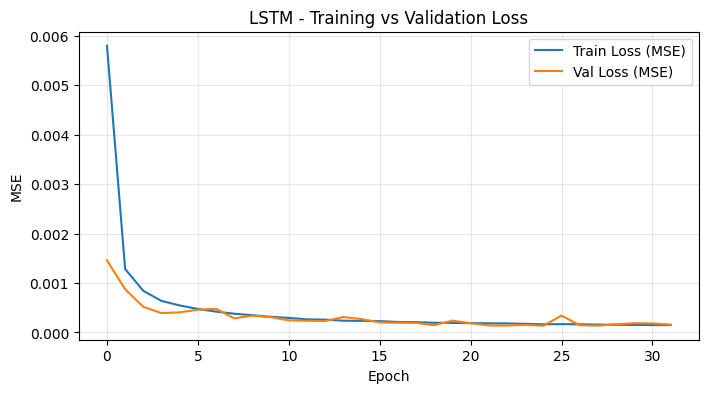

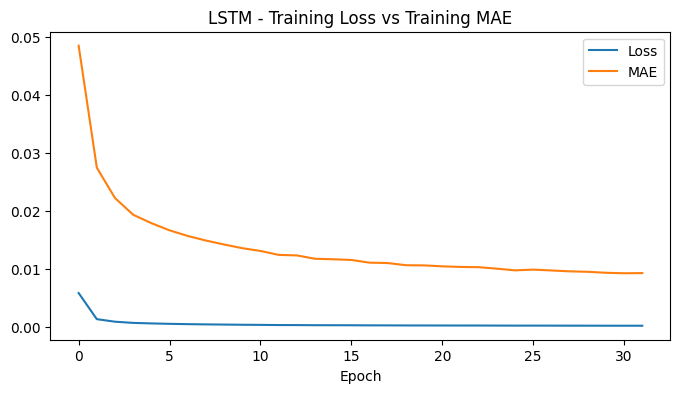

315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step

 Overall Evaluation for ERCOT (Original Scale - MW)
MSE: 459738.0401364236
RMSE: 678.0398514367895
MAE: 494.46776450899404
MAPE: 0.8747308381399329 %


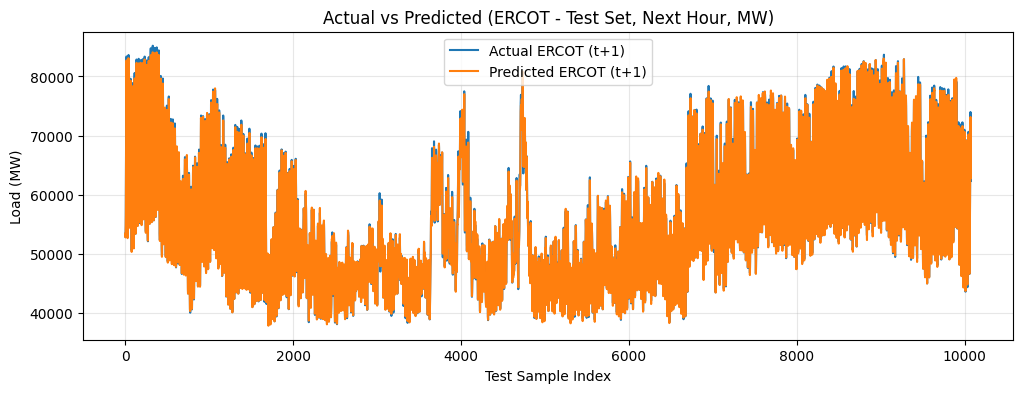

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


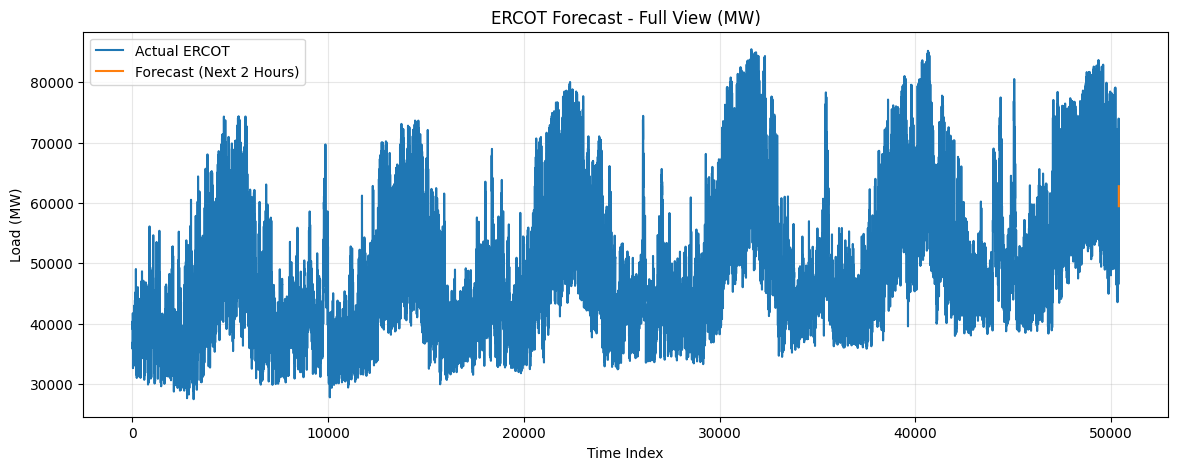

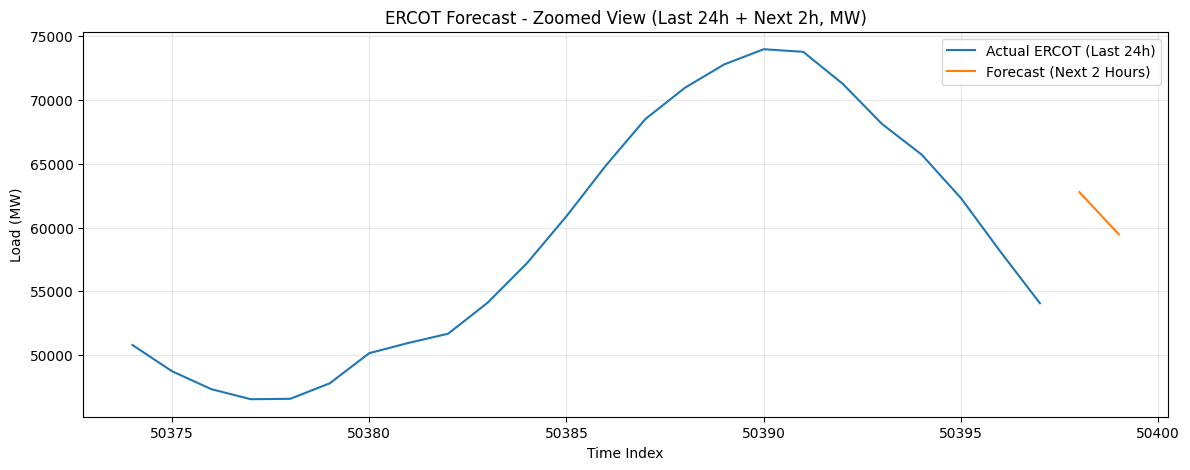

In [26]:
# LSTM (Multiple features) - Evaluation
# ------------------------------------------------------------
# 8. Training Curves (train vs val)
# ------------------------------------------------------------

print("Training Loss:", history.history['loss'])
print("Training MAE:", history.history['mae'])

# Loss plot
pyplot.figure(figsize=(8,4))
pyplot.plot(history.history['loss'], label='Train Loss (MSE)')
pyplot.plot(history.history['val_loss'], label='Val Loss (MSE)')
pyplot.title('LSTM - Training vs Validation Loss')
pyplot.xlabel('Epoch')
pyplot.ylabel('MSE')
pyplot.legend()
pyplot.grid(True, alpha=0.3)
pyplot.show()

# PLOT 1: Loss vs MAE
pyplot.figure(figsize=(8,4))
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['mae'])
pyplot.title('LSTM - Training Loss vs Training MAE')
pyplot.xlabel('Epoch')
pyplot.legend(['Loss', 'MAE'], loc='upper right')
pyplot.show()

# ------------------------------------------------------------
# 9. Predict on Test Set
# ------------------------------------------------------------

y_pred = model.predict(X_test)    # shape: (n_test_samples, horizon)
y_true = y_test                   # shape: (n_test_samples, horizon)

# ------------------------------------------------------------
# 10. INVERSE SCALING for metrics (MW)
# ------------------------------------------------------------

# Flatten horizon dimension: (N*horizon, 1)
y_pred_scaled = y_pred.reshape(-1, 1)
y_true_scaled = y_true.reshape(-1, 1)

n_flat = y_pred_scaled.shape[0]

# Build full feature arrays for inverse_transform
pred_full_scaled = np.zeros((n_flat, num_features))
true_full_scaled = np.zeros((n_flat, num_features))

# Put ERCOT values into correct column
pred_full_scaled[:, ercot_idx] = y_pred_scaled[:, 0]
true_full_scaled[:, ercot_idx] = y_true_scaled[:, 0]

# Inverse transform to original scale
pred_full = scaler.inverse_transform(pred_full_scaled)
true_full = scaler.inverse_transform(true_full_scaled)

# Extract ERCOT column (in MW)
y_pred_inv = pred_full[:, ercot_idx]   # shape: (N*horizon,)
y_true_inv = true_full[:, ercot_idx]

# Metrics in MW
mse = mean_squared_error(y_true_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_inv, y_pred_inv)

eps = 1e-6  # to avoid divide-by-zero
mape = np.mean(np.abs((y_true_inv - y_pred_inv) / (y_true_inv + eps))) * 100

print("\n Overall Evaluation for ERCOT (Original Scale - MW)")
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape, "%")

# ------------------------------------------------------------
# 11. ERCOT Plot (t+1) in MW
# ------------------------------------------------------------

n_samples_test = y_true.shape[0]

# reshape back to (samples, horizon)
y_true_inv_seq = y_true_inv.reshape(n_samples_test, horizon)
y_pred_inv_seq = y_pred_inv.reshape(n_samples_test, horizon)

actual_test_ercot_t1 = y_true_inv_seq[:, 0]   # t+1
pred_test_ercot_t1   = y_pred_inv_seq[:, 0]

pyplot.figure(figsize=(12,4))
pyplot.plot(actual_test_ercot_t1, label='Actual ERCOT (t+1)')
pyplot.plot(pred_test_ercot_t1, label='Predicted ERCOT (t+1)')
pyplot.title("Actual vs Predicted (ERCOT - Test Set, Next Hour, MW)")
pyplot.xlabel("Test Sample Index")
pyplot.ylabel("Load (MW)")
pyplot.grid(True, alpha=0.3)
pyplot.legend()
pyplot.show()

# ------------------------------------------------------------
# 12. Forecasting Next 2 Hours for ERCOT (MW)
# ------------------------------------------------------------

last_window = X_test[-1].reshape(1, window, num_features)
future_pred_scaled = model.predict(last_window).reshape(horizon, 1)

# Build full feature vectors for inverse scaling
dummy_future_scaled = np.zeros((horizon, num_features))
dummy_future_scaled[:, ercot_idx] = future_pred_scaled[:, 0]

future_full = scaler.inverse_transform(dummy_future_scaled)
future_pred_ercot = future_full[:, ercot_idx]  # ERCOT in MW for next 2 hours

# Actual ERCOT history (inverse-scaled)
ercot_scaled_all = scaled_df[['ercot']].values
dummy_all_scaled = np.zeros((ercot_scaled_all.shape[0], num_features))
dummy_all_scaled[:, ercot_idx] = ercot_scaled_all[:, 0]
ercot_full = scaler.inverse_transform(dummy_all_scaled)
actual_series_ercot = ercot_full[:, ercot_idx]

future_x = np.arange(len(actual_series_ercot), len(actual_series_ercot) + horizon)

# Full series + forecast
pyplot.figure(figsize=(14,5))
pyplot.title("ERCOT Forecast - Full View (MW)")
pyplot.plot(np.arange(len(actual_series_ercot)), actual_series_ercot, label="Actual ERCOT")
pyplot.plot(future_x, future_pred_ercot, label="Forecast (Next 2 Hours)")
pyplot.xlabel("Time Index")
pyplot.ylabel("Load (MW)")
pyplot.grid(True, alpha=0.3)
pyplot.legend()
pyplot.show()

# Zoomed (last 24h + next 2h)
zoom_window = 24
start = len(actual_series_ercot) - zoom_window

pyplot.figure(figsize=(14,5))
pyplot.title("ERCOT Forecast - Zoomed View (Last 24h + Next 2h, MW)")
pyplot.plot(np.arange(start, len(actual_series_ercot)),
            actual_series_ercot[start:], label="Actual ERCOT (Last 24h)")
pyplot.plot(future_x, future_pred_ercot, label="Forecast (Next 2 Hours)")
pyplot.xlabel("Time Index")
pyplot.ylabel("Load (MW)")
pyplot.grid(True, alpha=0.3)
pyplot.legend()
pyplot.show()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.0078 - mae: 0.0540 - val_loss: 0.0010 - val_mae: 0.0253
Epoch 2/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0010 - mae: 0.0245 - val_loss: 6.0777e-04 - val_mae: 0.0188
Epoch 3/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 6.8551e-04 - mae: 0.0200 - val_loss: 6.5308e-04 - val_mae: 0.0203
Epoch 4/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 5.1883e-04 - mae: 0.0175 - val_loss: 3.4805e-04 - val_mae: 0.0144
Epoch 5/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 4.3382e-04 - mae: 0.0159 - val_loss: 3.3459e-04 - val_mae: 0.0139
Epoch 6/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 3.8511e-04 - mae: 0.0150 - val_loss: 2.8309e-04 - val_mae: 0.0126
Epoch 7/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 3.3730e-04 - mae: 0.0140 - val_loss: 2.4908e-04 - val_mae: 0.0120
Epoch 8/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 3.0552e-04 - mae: 0.0133 - val_loss: 3.1249e-04 - val

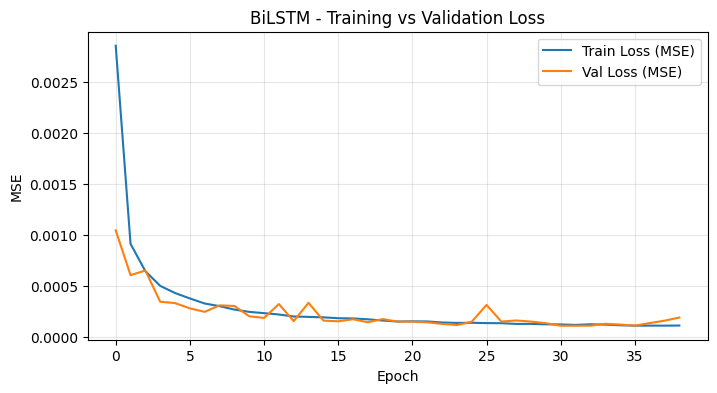

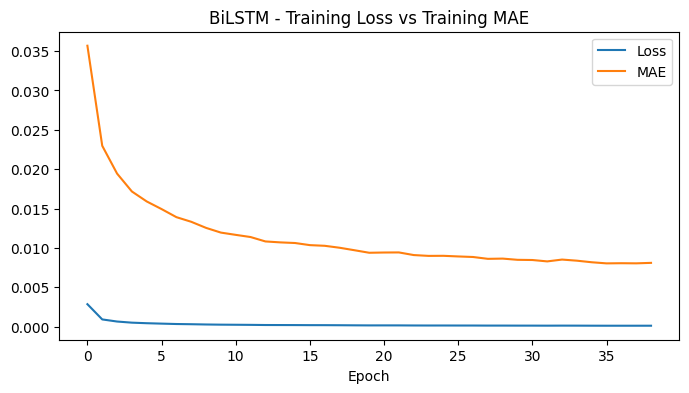

315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

 Overall Evaluation for ERCOT (Original Scale - MW)
MSE: 381273.9497998387
RMSE: 617.4738454378765
MAE: 448.66164300338403
MAPE: 0.7977509087651053 %


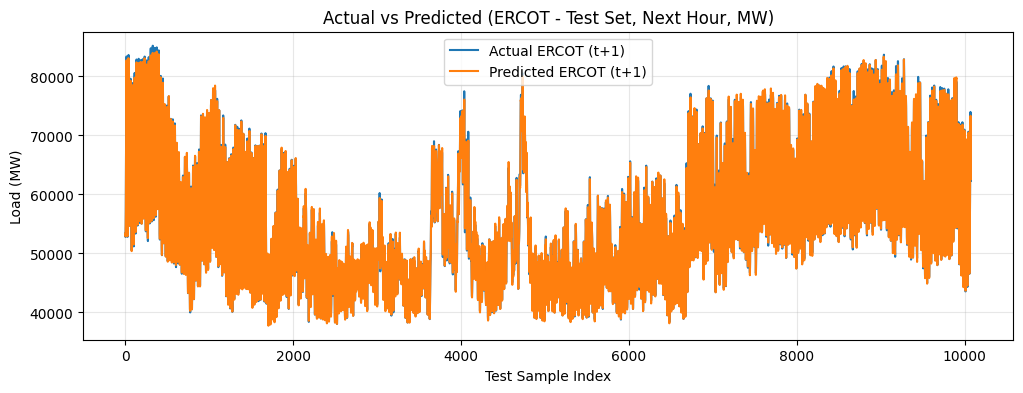

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


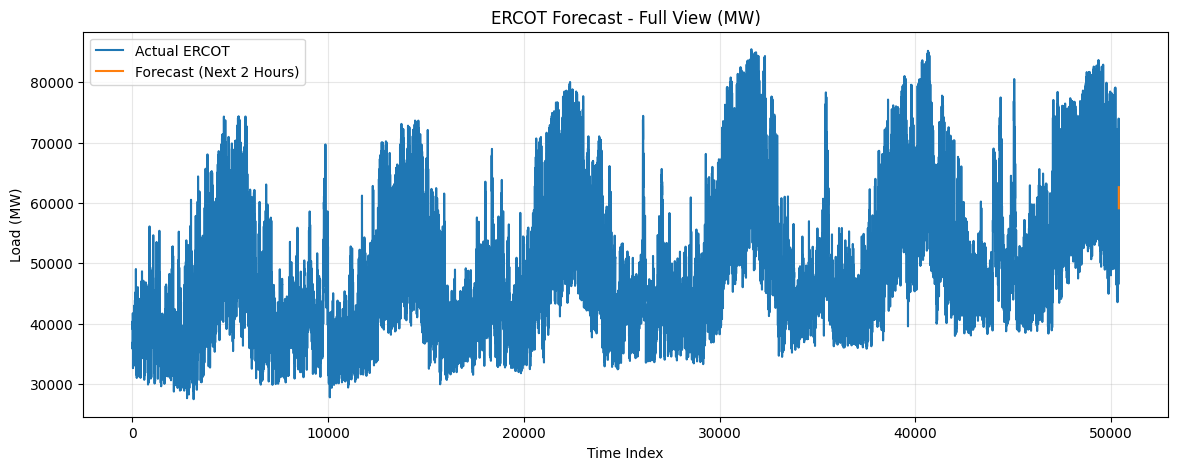

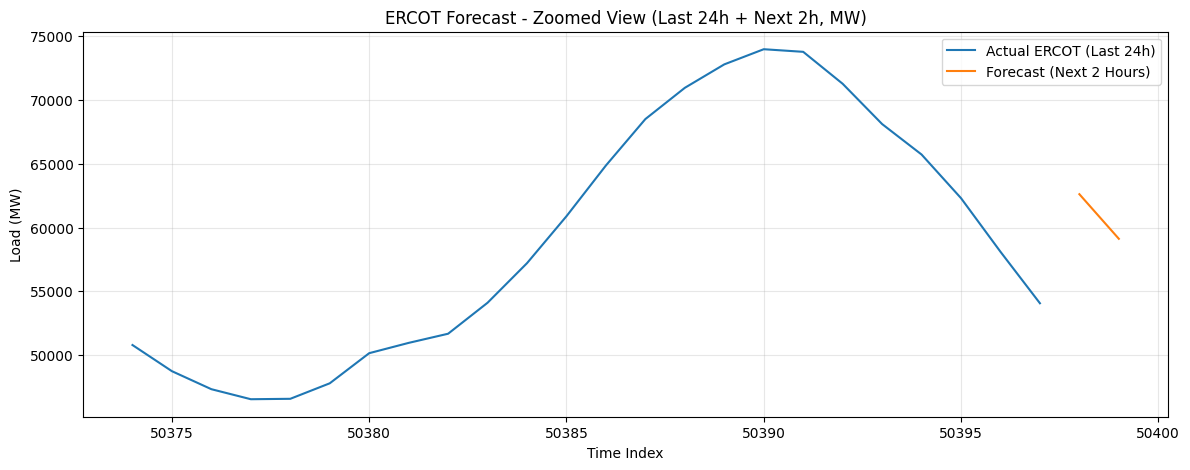

In [2]:
# ------------------------------------------------------------
# 6. Build BiLSTM Model (output = horizon values for ERCOT)
# ------------------------------------------------------------

model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(window, num_features)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32, activation='relu'))
model.add(Dense(horizon))   # <<< horizon outputs for ERCOT only

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

es = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# ------------------------------------------------------------
# 7. Train
# ------------------------------------------------------------

history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[es],
    verbose=1
)

# ------------------------------------------------------------
# 8. Training Curves (train vs val)
# ------------------------------------------------------------

print("Training Loss:", history.history['loss'])
print("Training MAE:", history.history['mae'])

# Loss plot
pyplot.figure(figsize=(8,4))
pyplot.plot(history.history['loss'], label='Train Loss (MSE)')
pyplot.plot(history.history['val_loss'], label='Val Loss (MSE)')
pyplot.title('BiLSTM - Training vs Validation Loss')
pyplot.xlabel('Epoch')
pyplot.ylabel('MSE')
pyplot.legend()
pyplot.grid(True, alpha=0.3)
pyplot.show()

# PLOT 1: Loss vs MAE
pyplot.figure(figsize=(8,4))
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['mae'])
pyplot.title('BiLSTM - Training Loss vs Training MAE')
pyplot.xlabel('Epoch')
pyplot.legend(['Loss', 'MAE'], loc='upper right')
pyplot.show()

# ------------------------------------------------------------
# 9. Predict on Test Set
# ------------------------------------------------------------

y_pred = model.predict(X_test)    # shape: (n_test_samples, horizon)
y_true = y_test                   # shape: (n_test_samples, horizon)

# ------------------------------------------------------------
# 10. INVERSE SCALING for metrics (MW)
# ------------------------------------------------------------

# Flatten horizon dimension: (N*horizon, 1)
y_pred_scaled = y_pred.reshape(-1, 1)
y_true_scaled = y_true.reshape(-1, 1)

n_flat = y_pred_scaled.shape[0]

# Build full feature arrays for inverse_transform
pred_full_scaled = np.zeros((n_flat, num_features))
true_full_scaled = np.zeros((n_flat, num_features))

# Put ERCOT values into correct column
pred_full_scaled[:, ercot_idx] = y_pred_scaled[:, 0]
true_full_scaled[:, ercot_idx] = y_true_scaled[:, 0]

# Inverse transform to original scale
pred_full = scaler.inverse_transform(pred_full_scaled)
true_full = scaler.inverse_transform(true_full_scaled)

# Extract ERCOT column (in MW)
y_pred_inv = pred_full[:, ercot_idx]   # shape: (N*horizon,)
y_true_inv = true_full[:, ercot_idx]

# Metrics in MW
mse = mean_squared_error(y_true_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_inv, y_pred_inv)

eps = 1e-6  # to avoid divide-by-zero
mape = np.mean(np.abs((y_true_inv - y_pred_inv) / (y_true_inv + eps))) * 100

print("\n Overall Evaluation for ERCOT (Original Scale - MW)")
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape, "%")

# ------------------------------------------------------------
# 11. ERCOT Plot (t+1) in MW
# ------------------------------------------------------------

n_samples_test = y_true.shape[0]

# reshape back to (samples, horizon)
y_true_inv_seq = y_true_inv.reshape(n_samples_test, horizon)
y_pred_inv_seq = y_pred_inv.reshape(n_samples_test, horizon)

actual_test_ercot_t1 = y_true_inv_seq[:, 0]   # t+1
pred_test_ercot_t1   = y_pred_inv_seq[:, 0]

pyplot.figure(figsize=(12,4))
pyplot.plot(actual_test_ercot_t1, label='Actual ERCOT (t+1)')
pyplot.plot(pred_test_ercot_t1, label='Predicted ERCOT (t+1)')
pyplot.title("Actual vs Predicted (ERCOT - Test Set, Next Hour, MW)")
pyplot.xlabel("Test Sample Index")
pyplot.ylabel("Load (MW)")
pyplot.grid(True, alpha=0.3)
pyplot.legend()
pyplot.show()

# ------------------------------------------------------------
# 12. Forecasting Next 2 Hours for ERCOT (MW)
# ------------------------------------------------------------

last_window = X_test[-1].reshape(1, window, num_features)
future_pred_scaled = model.predict(last_window).reshape(horizon, 1)

# Build full feature vectors for inverse scaling
dummy_future_scaled = np.zeros((horizon, num_features))
dummy_future_scaled[:, ercot_idx] = future_pred_scaled[:, 0]

future_full = scaler.inverse_transform(dummy_future_scaled)
future_pred_ercot = future_full[:, ercot_idx]  # ERCOT in MW for next 2 hours

# Actual ERCOT history (inverse-scaled)
ercot_scaled_all = scaled_df[['ercot']].values
dummy_all_scaled = np.zeros((ercot_scaled_all.shape[0], num_features))
dummy_all_scaled[:, ercot_idx] = ercot_scaled_all[:, 0]
ercot_full = scaler.inverse_transform(dummy_all_scaled)
actual_series_ercot = ercot_full[:, ercot_idx]

future_x = np.arange(len(actual_series_ercot), len(actual_series_ercot) + horizon)

# Full series + forecast
pyplot.figure(figsize=(14,5))
pyplot.title("ERCOT Forecast - Full View (MW)")
pyplot.plot(np.arange(len(actual_series_ercot)), actual_series_ercot, label="Actual ERCOT")
pyplot.plot(future_x, future_pred_ercot, label="Forecast (Next 2 Hours)")
pyplot.xlabel("Time Index")
pyplot.ylabel("Load (MW)")
pyplot.grid(True, alpha=0.3)
pyplot.legend()
pyplot.show()

# Zoomed (last 24h + next 2h)
zoom_window = 24
start = len(actual_series_ercot) - zoom_window

pyplot.figure(figsize=(14,5))
pyplot.title("ERCOT Forecast - Zoomed View (Last 24h + Next 2h, MW)")
pyplot.plot(np.arange(start, len(actual_series_ercot)),
            actual_series_ercot[start:], label="Actual ERCOT (Last 24h)")
pyplot.plot(future_x, future_pred_ercot, label="Forecast (Next 2 Hours)")
pyplot.xlabel("Time Index")
pyplot.ylabel("Load (MW)")
pyplot.grid(True, alpha=0.3)
pyplot.legend()
pyplot.show()


In [23]:
# GRU - Multiple Features
model = Sequential()
model.add(GRU(64, return_sequences=True, input_shape=(window, num_features)))
model.add(Dropout(0.3))
model.add(GRU(32))
model.add(Dense(32, activation='relu'))
model.add(Dense(horizon))  # predicting next 2 hours

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Early stopping
es = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train Model
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[es],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - loss: 0.0212 - mae: 0.0813 - val_loss: 9.5016e-04 - val_mae: 0.0238
Epoch 2/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - loss: 0.0012 - mae: 0.0268 - val_loss: 5.6746e-04 - val_mae: 0.0180
Epoch 3/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - loss: 7.7233e-04 - mae: 0.0215 - val_loss: 4.2845e-04 - val_mae: 0.0157
Epoch 4/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - loss: 6.4219e-04 - mae: 0.0194 - val_loss: 7.8479e-04 - val_mae: 0.0232
Epoch 5/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - loss: 5.2274e-04 - mae: 0.0175 - val_loss: 3.3696e-04 - val_mae: 0.0133
Epoch 6/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - loss: 4.6413e-04 - mae: 0.0165 - val_loss: 3.3742e-04 - val_mae: 0.0142
Epoch 7/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - loss: 4.2434e-04 - mae: 0.0157 - val_loss: 3.1213e-04 - val_mae: 0.0139
Epoch 8/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - loss: 3.8295e-04 - mae: 0.0149 - val_loss: 3.697

Training Loss: [0.006290762685239315, 0.0010732753435149789, 0.0007373120752163231, 0.0005944346776232123, 0.0005140372086316347, 0.0004563711991067976, 0.0004198547394480556, 0.0003779396938625723, 0.00036265875678509474, 0.0003300666285213083, 0.0003081771719735116, 0.0002907946181949228, 0.0002870348689612001, 0.0002645549539010972, 0.0002530351048335433, 0.00023069078451953828, 0.00022523626103065908, 0.00022288342006504536, 0.00020391514408402145, 0.00019696567323990166, 0.0001983676920644939, 0.00018774000636767596, 0.00017612958617974073, 0.0001755664125084877, 0.00017716723959892988, 0.00017311870760750026, 0.00016384542686864734, 0.00016091483121272177, 0.0001602770498720929, 0.00015411360072903335, 0.00015395268565043807, 0.0001503007806604728, 0.00015028135385364294, 0.00014060360263101757, 0.00014200179430190474, 0.00013879318430554122, 0.00013798210420645773, 0.0001364126947009936, 0.0001339758891845122, 0.00013644847786054015]
Training MAE: [0.04750579968094826, 0.0252105

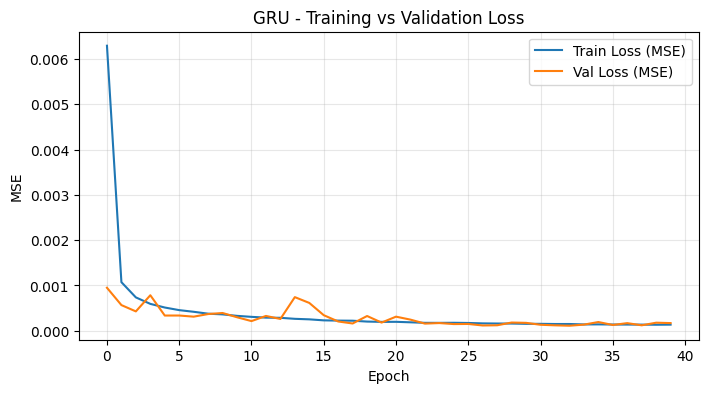

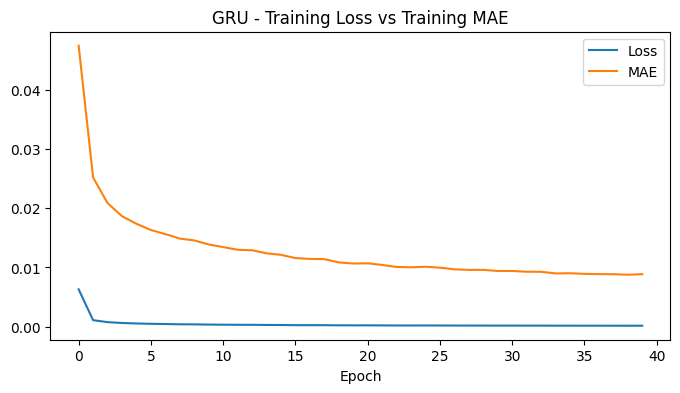

315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step

 Overall Evaluation for ERCOT (Original Scale - MW)
MSE: 377544.4120365674
RMSE: 614.4464273120703
MAE: 456.6190135594176
MAPE: 0.8212419780897224 %


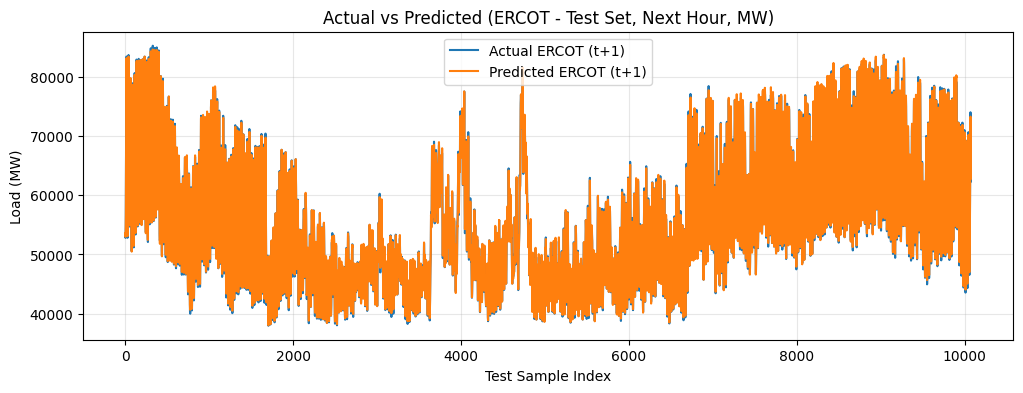

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


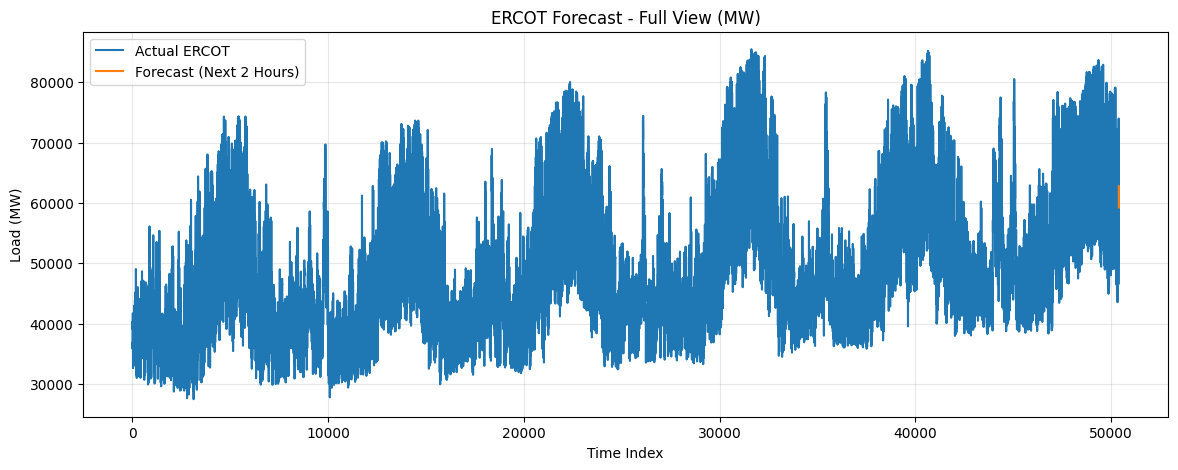

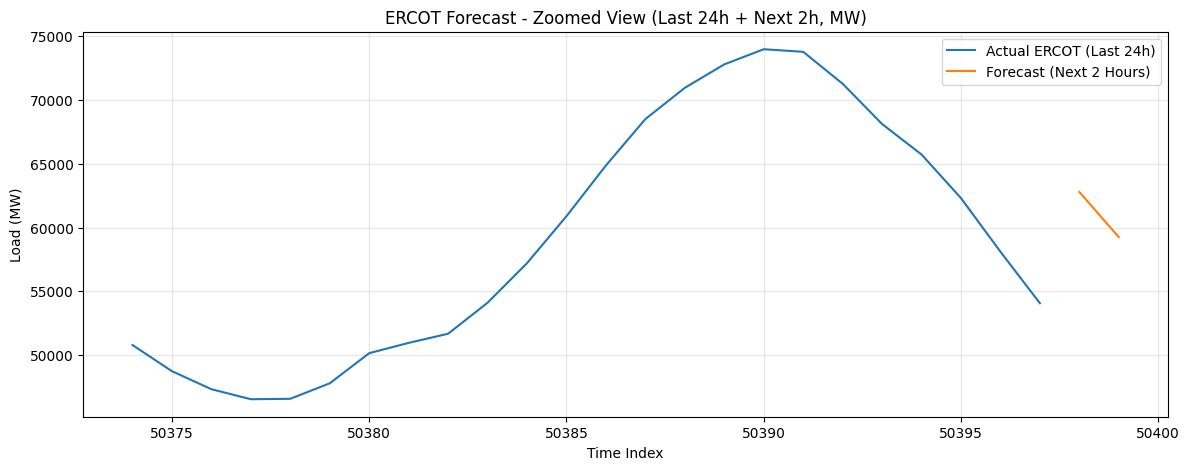

In [24]:
# GRU (Multiple features) - Evaluation
# ------------------------------------------------------------
# 8. Training Curves (train vs val)
# ------------------------------------------------------------

print("Training Loss:", history.history['loss'])
print("Training MAE:", history.history['mae'])

# Loss plot
pyplot.figure(figsize=(8,4))
pyplot.plot(history.history['loss'], label='Train Loss (MSE)')
pyplot.plot(history.history['val_loss'], label='Val Loss (MSE)')
pyplot.title('GRU - Training vs Validation Loss')
pyplot.xlabel('Epoch')
pyplot.ylabel('MSE')
pyplot.legend()
pyplot.grid(True, alpha=0.3)
pyplot.show()

# PLOT 1: Loss vs MAE
pyplot.figure(figsize=(8,4))
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['mae'])
pyplot.title('GRU - Training Loss vs Training MAE')
pyplot.xlabel('Epoch')
pyplot.legend(['Loss', 'MAE'], loc='upper right')
pyplot.show()

# ------------------------------------------------------------
# 9. Predict on Test Set
# ------------------------------------------------------------

y_pred = model.predict(X_test)    # shape: (n_test_samples, horizon)
y_true = y_test                   # shape: (n_test_samples, horizon)

# ------------------------------------------------------------
# 10. INVERSE SCALING for metrics (MW)
# ------------------------------------------------------------

# Flatten horizon dimension: (N*horizon, 1)
y_pred_scaled = y_pred.reshape(-1, 1)
y_true_scaled = y_true.reshape(-1, 1)

n_flat = y_pred_scaled.shape[0]

# Build full feature arrays for inverse_transform
pred_full_scaled = np.zeros((n_flat, num_features))
true_full_scaled = np.zeros((n_flat, num_features))

# Put ERCOT values into correct column
pred_full_scaled[:, ercot_idx] = y_pred_scaled[:, 0]
true_full_scaled[:, ercot_idx] = y_true_scaled[:, 0]

# Inverse transform to original scale
pred_full = scaler.inverse_transform(pred_full_scaled)
true_full = scaler.inverse_transform(true_full_scaled)

# Extract ERCOT column (in MW)
y_pred_inv = pred_full[:, ercot_idx]   # shape: (N*horizon,)
y_true_inv = true_full[:, ercot_idx]

# Metrics in MW
mse = mean_squared_error(y_true_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_inv, y_pred_inv)

eps = 1e-6  # to avoid divide-by-zero
mape = np.mean(np.abs((y_true_inv - y_pred_inv) / (y_true_inv + eps))) * 100

print("\n Overall Evaluation for ERCOT (Original Scale - MW)")
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape, "%")

# ------------------------------------------------------------
# 11. ERCOT Plot (t+1) in MW
# ------------------------------------------------------------

n_samples_test = y_true.shape[0]

# reshape back to (samples, horizon)
y_true_inv_seq = y_true_inv.reshape(n_samples_test, horizon)
y_pred_inv_seq = y_pred_inv.reshape(n_samples_test, horizon)

actual_test_ercot_t1 = y_true_inv_seq[:, 0]   # t+1
pred_test_ercot_t1   = y_pred_inv_seq[:, 0]

pyplot.figure(figsize=(12,4))
pyplot.plot(actual_test_ercot_t1, label='Actual ERCOT (t+1)')
pyplot.plot(pred_test_ercot_t1, label='Predicted ERCOT (t+1)')
pyplot.title("Actual vs Predicted (ERCOT - Test Set, Next Hour, MW)")
pyplot.xlabel("Test Sample Index")
pyplot.ylabel("Load (MW)")
pyplot.grid(True, alpha=0.3)
pyplot.legend()
pyplot.show()

# ------------------------------------------------------------
# 12. Forecasting Next 2 Hours for ERCOT (MW)
# ------------------------------------------------------------

last_window = X_test[-1].reshape(1, window, num_features)
future_pred_scaled = model.predict(last_window).reshape(horizon, 1)

# Build full feature vectors for inverse scaling
dummy_future_scaled = np.zeros((horizon, num_features))
dummy_future_scaled[:, ercot_idx] = future_pred_scaled[:, 0]

future_full = scaler.inverse_transform(dummy_future_scaled)
future_pred_ercot = future_full[:, ercot_idx]  # ERCOT in MW for next 2 hours

# Actual ERCOT history (inverse-scaled)
ercot_scaled_all = scaled_df[['ercot']].values
dummy_all_scaled = np.zeros((ercot_scaled_all.shape[0], num_features))
dummy_all_scaled[:, ercot_idx] = ercot_scaled_all[:, 0]
ercot_full = scaler.inverse_transform(dummy_all_scaled)
actual_series_ercot = ercot_full[:, ercot_idx]

future_x = np.arange(len(actual_series_ercot), len(actual_series_ercot) + horizon)

# Full series + forecast
pyplot.figure(figsize=(14,5))
pyplot.title("ERCOT Forecast - Full View (MW)")
pyplot.plot(np.arange(len(actual_series_ercot)), actual_series_ercot, label="Actual ERCOT")
pyplot.plot(future_x, future_pred_ercot, label="Forecast (Next 2 Hours)")
pyplot.xlabel("Time Index")
pyplot.ylabel("Load (MW)")
pyplot.grid(True, alpha=0.3)
pyplot.legend()
pyplot.show()

# Zoomed (last 24h + next 2h)
zoom_window = 24
start = len(actual_series_ercot) - zoom_window

pyplot.figure(figsize=(14,5))
pyplot.title("ERCOT Forecast - Zoomed View (Last 24h + Next 2h, MW)")
pyplot.plot(np.arange(start, len(actual_series_ercot)),
            actual_series_ercot[start:], label="Actual ERCOT (Last 24h)")
pyplot.plot(future_x, future_pred_ercot, label="Forecast (Next 2 Hours)")
pyplot.xlabel("Time Index")
pyplot.ylabel("Load (MW)")
pyplot.grid(True, alpha=0.3)
pyplot.legend()
pyplot.show()

**Hyperparameter tuning**

In [3]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 28.7 MB/s eta 0:00:00


In [4]:
import optuna
from keras.optimizers import Adam

In [11]:
#multivariate
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from keras.callbacks import EarlyStopping
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Parameters
window = 24
horizon = 2
batch_size = 64
epochs = 100

# 1. Load dataset
df = pd.read_excel("ercot_cleaned.xlsx")
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

# 2. ADD DATETIME FEATURES
df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["month"] = df.index.month

# 3. Select features
feature_cols = [
    'coast','east','fwest','north','ncent','south','scent','west','ercot',
    'hour','dayofweek','month'
]

data = df[feature_cols]

num_features = len(feature_cols)
num_outputs = 1    # <<< ONLY ERCOT is predicted
ercot_idx = data.columns.get_loc('ercot')  # index of 'ercot' column

# ------------------------------------------------------------
# 3.5 Train/Test SPLIT at DATA LEVEL (for scaling)
# ------------------------------------------------------------

split_idx_rows = int(0.8 * len(data))
train_data = data.iloc[:split_idx_rows]
test_data  = data.iloc[split_idx_rows:]

# ------------------------------------------------------------
# 4. Scaling - FIT ONLY ON TRAIN
# ------------------------------------------------------------

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data)     # fit on train
scaled_test  = scaler.transform(test_data)         # transform test

# Recombine to keep full time continuity for windowing
scaled = np.vstack([scaled_train, scaled_test])
scaled_df = pd.DataFrame(scaled, index=data.index, columns=data.columns)

# ------------------------------------------------------------
# 5. Create windows (multivariate X, univariate Y = ERCOT)
# ------------------------------------------------------------

def make_windows(df, window, horizon, target_col_idx):
    X, y = [], []
    arr = df.values
    for i in range(len(arr) - window - horizon):
        # past window of ALL features
        X.append(arr[i:i+window, :])
        # next horizon steps of ONLY target column (ercot)
        y.append(arr[i+window:i+window+horizon, target_col_idx])
    return np.array(X), np.array(y)

X, y = make_windows(scaled_df, window, horizon, ercot_idx)
# y shape: (samples, horizon)

# Train/test split at sample level
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [6]:
def build_bilstm_model(trial, window, num_features, horizon):
    """
    Build a BiLSTM model whose hyperparameters are decided by Optuna.
    """

    # -------- Hyperparameters to tune --------
    # Number of units in the first BiLSTM layer
    lstm1_units = trial.suggest_int("lstm1_units", 32, 128, step=32)
    # Number of units in the second BiLSTM layer
    lstm2_units = trial.suggest_int("lstm2_units", 16, 64, step=16)
    # Dropout rate
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    # Number of neurons in the Dense layer
    dense_units = trial.suggest_int("dense_units", 16, 64, step=16)
    # Learning rate for Adam
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    # Whether to use one or two BiLSTM layers
    use_two_layers = trial.suggest_categorical("use_two_layers", [True, False])

    # -------- Build model --------
    model = Sequential()

    # First BiLSTM layer
    model.add(
        Bidirectional(
            LSTM(lstm1_units, return_sequences=use_two_layers),
            input_shape=(window, num_features)
        )
    )
    model.add(Dropout(dropout_rate))

    # Optional second BiLSTM layer
    if use_two_layers:
        model.add(Bidirectional(LSTM(lstm2_units)))
    else:
        # If no second LSTM, we already returned sequences=False in first LSTM
        pass

    # Dense + output
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(horizon))   # predicting next 2 hours for ERCOT

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model

In [7]:
def objective(trial):
    """
    Optuna objective: build a model, train it, and return validation loss (MSE).
    """

    # Build model with current trial's hyperparameters
    model = build_bilstm_model(trial, window=window, num_features=num_features, horizon=horizon)

    # Early stopping (you can tune patience too if you want)
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # You can also tune batch size if you like:
    batch_size_trial = trial.suggest_categorical("batch_size", [32, 64, 128])

    history = model.fit(
        X_train, y_train,
        batch_size=batch_size_trial,
        epochs=40,               # fewer epochs during tuning to save time
        validation_data=(X_test, y_test),
        callbacks=[es],
        verbose=0                # silent during tuning
    )

    # Use the best validation loss achieved during training as the objective
    val_losses = history.history["val_loss"]
    best_val_loss = min(val_losses)

    # You can also log other metrics to the trial if desired
    trial.set_user_attr("best_epoch", np.argmin(val_losses))

    return best_val_loss

In [8]:
# ------------------------------------------------------------
# Run Optuna study
# ------------------------------------------------------------
study = optuna.create_study(direction="minimize")  # we want to minimize val_loss (MSE)
study.optimize(objective, n_trials=20)             # <-- change n_trials as you like (e.g., 30, 50)

print("\nBest trial:")
best_trial = study.best_trial
print("  Value (best val_loss): ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-12-09 17:36:31,000] A new study created in memory with name: no-name-0fba7715-0540-4e21-b91b-c91696a2ca7e
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-12-09 17:39:47,269] Trial 0 finished with value: 0.00012464057363104075 and parameters: {'lstm1_units': 96, 'lstm2_units': 32, 'dropout_rate': 0.30000000000000004, 'dense_units': 16, 'learning_rate': 0.0006255502585350682, 'use_two_layers': True, 'batch_size': 64}. Best is trial 0 with value: 0.00012464057363104075.
[I 2025-12-09 17:40:30,730] Trial 1 finished with value: 0.00021035686950199306 and parameters: {'lstm1_units': 128, 'lstm2_units': 16, 'dropout_rate': 0.5, 'dense_units': 48, 'learning_rate': 0.008097691077755475, 'use_two_layers': True, 'batch_size': 128}. Best 


Best trial:
  Value (best val_loss):  0.00010230277257505804
  Params: 
    lstm1_units: 96
    lstm2_units: 64
    dropout_rate: 0.2
    dense_units: 64
    learning_rate: 0.0023255785699153463
    use_two_layers: True
    batch_size: 128


In [9]:
# ------------------------------------------------------------
# Build FINAL model with best hyperparameters
# ------------------------------------------------------------

best_params = study.best_trial.params
print("\nUsing best hyperparameters to train final BiLSTM model:")

def build_final_bilstm(best_params, window, num_features, horizon):
    model = Sequential()

    lstm1_units = best_params["lstm1_units"]
    lstm2_units = best_params["lstm2_units"]
    dropout_rate = best_params["dropout_rate"]
    dense_units = best_params["dense_units"]
    learning_rate = best_params["learning_rate"]
    use_two_layers = best_params["use_two_layers"]

    model.add(
        Bidirectional(
            LSTM(lstm1_units, return_sequences=use_two_layers),
            input_shape=(window, num_features)
        )
    )
    model.add(Dropout(dropout_rate))

    if use_two_layers:
        model.add(Bidirectional(LSTM(lstm2_units)))

    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(horizon))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model

model = build_final_bilstm(best_params, window=window, num_features=num_features, horizon=horizon)

es_final = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    batch_size=best_params["batch_size"],
    epochs=epochs,                # use your original 100 if you want
    validation_data=(X_test, y_test),
    callbacks=[es_final],
    verbose=1
)


Using best hyperparameters to train final BiLSTM model:
Epoch 1/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0065 - mae: 0.0466 - val_loss: 5.8354e-04 - val_mae: 0.0182
Epoch 2/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 7.2170e-04 - mae: 0.0205 - val_loss: 9.4309e-04 - val_mae: 0.0243
Epoch 3/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 5.1424e-04 - mae: 0.0172 - val_loss: 3.9319e-04 - val_mae: 0.0153
Epoch 4/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 3.9233e-04 - mae: 0.0151 - val_loss: 3.8091e-04 - val_mae: 0.0145
Epoch 5/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 3.3154e-04 - mae: 0.0139 - val_loss: 2.5660e-04 - val_mae: 0.0123
Epoch 6/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 2.9616e-04 - mae: 0.0131 - val_loss: 2.9992e-04 - val_mae: 0.0128
Epoch 7/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 2.9779e-04 - mae: 0.0132 - val_loss: 2.7256e-04 - val_mae: 0.0126
Epoch 8/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/st

Training Loss: [0.0022260856349021196, 0.000674172246363014, 0.00046529120299965143, 0.00037996171158738434, 0.0003219653444830328, 0.00031089159892871976, 0.0002815935295075178, 0.00025863744667731225, 0.0002404747938271612, 0.00021175903384573758, 0.0002028413728112355, 0.0001828027016017586, 0.00017642378224991262, 0.00018264354730490595, 0.0001615066867088899, 0.00015736786008346826, 0.00015622552018612623, 0.0001497044286224991, 0.0001509777212049812, 0.00014533406647387892, 0.00012777457595802844, 0.00013414668501354754, 0.00012725604756269604, 0.00013038241013418883, 0.00012401904677972198, 0.000119220552733168, 0.00012034633982693776, 0.00012243117089383304, 0.00011639569129329175, 0.00011276965960860252, 0.00011208996147615835, 0.00011228302901145071, 0.0001034428714774549, 0.00010125741391675547, 0.0001110989396693185, 9.709407459013164e-05, 9.645650425227359e-05, 0.00010203941201325506]
Training MAE: [0.03005947358906269, 0.01979636959731579, 0.016395796090364456, 0.01488561

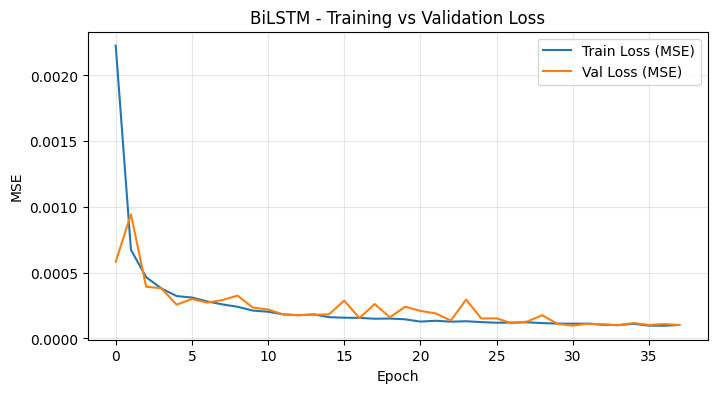

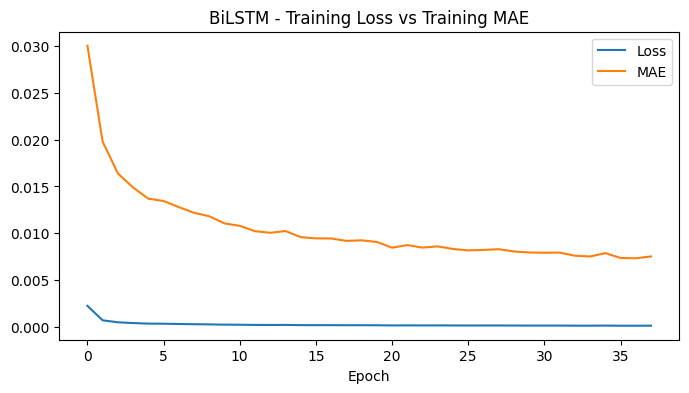

315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

 Overall Evaluation for ERCOT (Original Scale - MW)
MSE: 326789.7072843562
RMSE: 571.6552346339148
MAE: 410.51979766708155
MAPE: 0.732815265599674 %


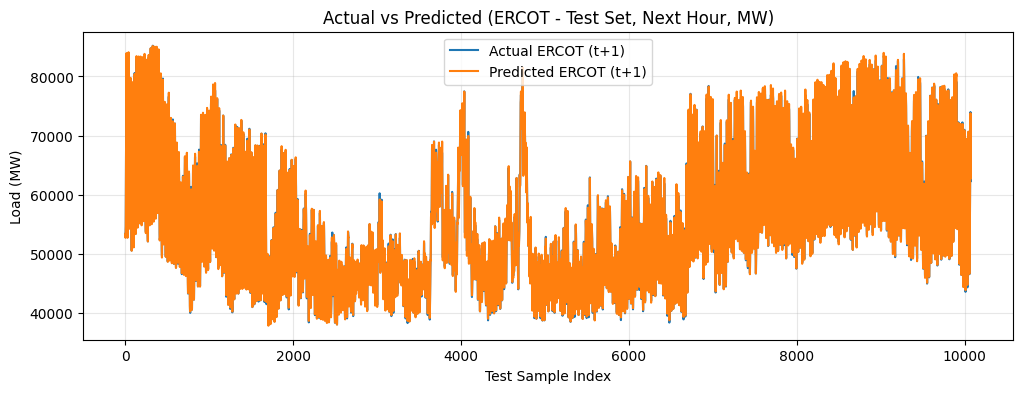

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


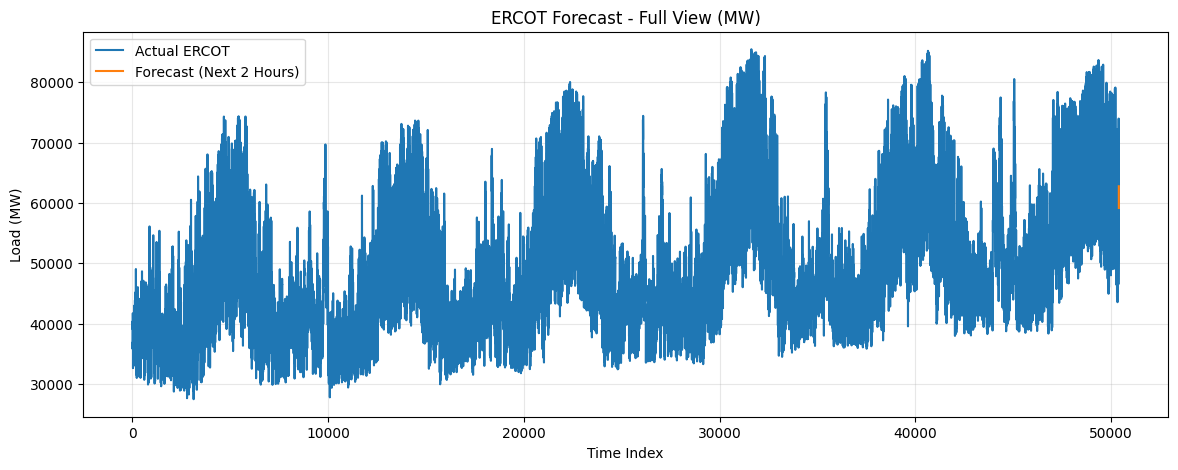

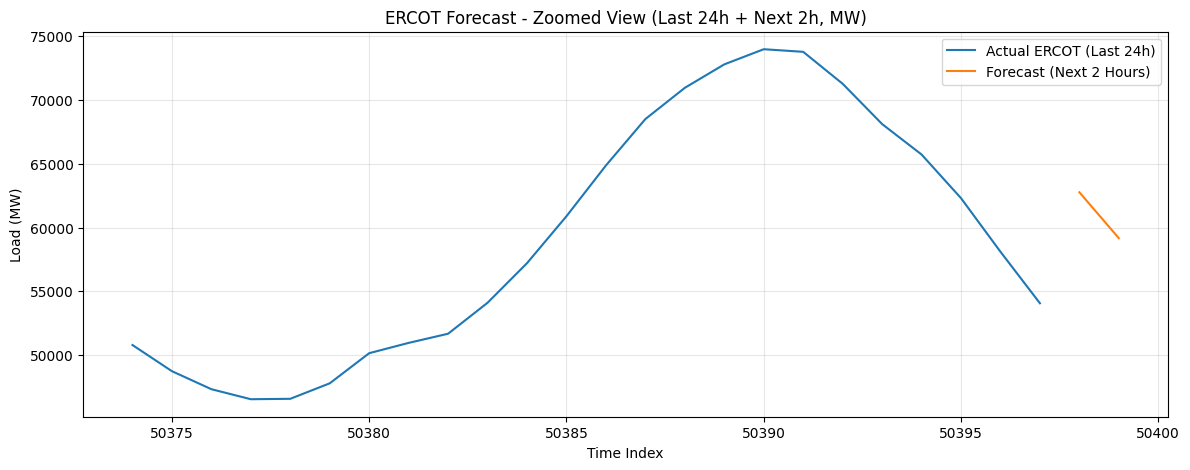

In [10]:
# ------------------------------------------------------------
# 8. Training Curves (train vs val)
# ------------------------------------------------------------

print("Training Loss:", history.history['loss'])
print("Training MAE:", history.history['mae'])

# Loss plot
pyplot.figure(figsize=(8,4))
pyplot.plot(history.history['loss'], label='Train Loss (MSE)')
pyplot.plot(history.history['val_loss'], label='Val Loss (MSE)')
pyplot.title('BiLSTM - Training vs Validation Loss')
pyplot.xlabel('Epoch')
pyplot.ylabel('MSE')
pyplot.legend()
pyplot.grid(True, alpha=0.3)
pyplot.show()

# PLOT 1: Loss vs MAE
pyplot.figure(figsize=(8,4))
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['mae'])
pyplot.title('BiLSTM - Training Loss vs Training MAE')
pyplot.xlabel('Epoch')
pyplot.legend(['Loss', 'MAE'], loc='upper right')
pyplot.show()

# ------------------------------------------------------------
# 9. Predict on Test Set
# ------------------------------------------------------------

y_pred = model.predict(X_test)    # shape: (n_test_samples, horizon)
y_true = y_test                   # shape: (n_test_samples, horizon)

# ------------------------------------------------------------
# 10. INVERSE SCALING for metrics (MW)
# ------------------------------------------------------------

# Flatten horizon dimension: (N*horizon, 1)
y_pred_scaled = y_pred.reshape(-1, 1)
y_true_scaled = y_true.reshape(-1, 1)

n_flat = y_pred_scaled.shape[0]

# Build full feature arrays for inverse_transform
pred_full_scaled = np.zeros((n_flat, num_features))
true_full_scaled = np.zeros((n_flat, num_features))

# Put ERCOT values into correct column
pred_full_scaled[:, ercot_idx] = y_pred_scaled[:, 0]
true_full_scaled[:, ercot_idx] = y_true_scaled[:, 0]

# Inverse transform to original scale
pred_full = scaler.inverse_transform(pred_full_scaled)
true_full = scaler.inverse_transform(true_full_scaled)

# Extract ERCOT column (in MW)
y_pred_inv = pred_full[:, ercot_idx]   # shape: (N*horizon,)
y_true_inv = true_full[:, ercot_idx]

# Metrics in MW
mse = mean_squared_error(y_true_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_inv, y_pred_inv)

eps = 1e-6  # to avoid divide-by-zero
mape = np.mean(np.abs((y_true_inv - y_pred_inv) / (y_true_inv + eps))) * 100

print("\n Overall Evaluation for ERCOT (Original Scale - MW)")
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape, "%")

# ------------------------------------------------------------
# 11. ERCOT Plot (t+1) in MW
# ------------------------------------------------------------

n_samples_test = y_true.shape[0]

# reshape back to (samples, horizon)
y_true_inv_seq = y_true_inv.reshape(n_samples_test, horizon)
y_pred_inv_seq = y_pred_inv.reshape(n_samples_test, horizon)

actual_test_ercot_t1 = y_true_inv_seq[:, 0]   # t+1
pred_test_ercot_t1   = y_pred_inv_seq[:, 0]

pyplot.figure(figsize=(12,4))
pyplot.plot(actual_test_ercot_t1, label='Actual ERCOT (t+1)')
pyplot.plot(pred_test_ercot_t1, label='Predicted ERCOT (t+1)')
pyplot.title("Actual vs Predicted (ERCOT - Test Set, Next Hour, MW)")
pyplot.xlabel("Test Sample Index")
pyplot.ylabel("Load (MW)")
pyplot.grid(True, alpha=0.3)
pyplot.legend()
pyplot.show()

# ------------------------------------------------------------
# 12. Forecasting Next 2 Hours for ERCOT (MW)
# ------------------------------------------------------------

last_window = X_test[-1].reshape(1, window, num_features)
future_pred_scaled = model.predict(last_window).reshape(horizon, 1)

# Build full feature vectors for inverse scaling
dummy_future_scaled = np.zeros((horizon, num_features))
dummy_future_scaled[:, ercot_idx] = future_pred_scaled[:, 0]

future_full = scaler.inverse_transform(dummy_future_scaled)
future_pred_ercot = future_full[:, ercot_idx]  # ERCOT in MW for next 2 hours

# Actual ERCOT history (inverse-scaled)
ercot_scaled_all = scaled_df[['ercot']].values
dummy_all_scaled = np.zeros((ercot_scaled_all.shape[0], num_features))
dummy_all_scaled[:, ercot_idx] = ercot_scaled_all[:, 0]
ercot_full = scaler.inverse_transform(dummy_all_scaled)
actual_series_ercot = ercot_full[:, ercot_idx]

future_x = np.arange(len(actual_series_ercot), len(actual_series_ercot) + horizon)

# Full series + forecast
pyplot.figure(figsize=(14,5))
pyplot.title("ERCOT Forecast - Full View (MW)")
pyplot.plot(np.arange(len(actual_series_ercot)), actual_series_ercot, label="Actual ERCOT")
pyplot.plot(future_x, future_pred_ercot, label="Forecast (Next 2 Hours)")
pyplot.xlabel("Time Index")
pyplot.ylabel("Load (MW)")
pyplot.grid(True, alpha=0.3)
pyplot.legend()
pyplot.show()

# Zoomed (last 24h + next 2h)
zoom_window = 24
start = len(actual_series_ercot) - zoom_window

pyplot.figure(figsize=(14,5))
pyplot.title("ERCOT Forecast - Zoomed View (Last 24h + Next 2h, MW)")
pyplot.plot(np.arange(start, len(actual_series_ercot)),
            actual_series_ercot[start:], label="Actual ERCOT (Last 24h)")
pyplot.plot(future_x, future_pred_ercot, label="Forecast (Next 2 Hours)")
pyplot.xlabel("Time Index")
pyplot.ylabel("Load (MW)")
pyplot.grid(True, alpha=0.3)
pyplot.legend()
pyplot.show()


In [12]:
from keras.layers import GRU   # add this
from keras.optimizers import Adam
import optuna

In [13]:
def build_gru_model(trial, window, num_features, horizon):
    """
    Build a GRU model whose hyperparameters are selected by Optuna.
    """

    # -------- Hyperparameters to tune --------
    gru1_units = trial.suggest_int("gru1_units", 32, 128, step=32)
    gru2_units = trial.suggest_int("gru2_units", 16, 64, step=16)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    dense_units = trial.suggest_int("dense_units", 16, 64, step=16)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    use_two_layers = trial.suggest_categorical("use_two_layers", [True, False])

    model = Sequential()

    # First GRU layer
    model.add(
        GRU(
            gru1_units,
            return_sequences=use_two_layers,   # if we use 2nd layer, need sequences
            input_shape=(window, num_features)
        )
    )
    model.add(Dropout(dropout_rate))

    # Optional second GRU layer
    if use_two_layers:
        model.add(GRU(gru2_units))

    # Dense + output
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(horizon))   # predicting next 2 hours

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model

In [14]:
def objective_gru(trial):
    """
    Optuna objective: build a GRU model, train it, and return validation loss (MSE).
    """

    model = build_gru_model(trial, window=window, num_features=num_features, horizon=horizon)

    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Tune batch size as well
    batch_size_trial = trial.suggest_categorical("batch_size", [32, 64, 128])

    history = model.fit(
        X_train, y_train,
        batch_size=batch_size_trial,
        epochs=40,              # fewer epochs during tuning
        validation_data=(X_test, y_test),
        callbacks=[es],
        verbose=0               # silent during tuning
    )

    val_losses = history.history["val_loss"]
    best_val_loss = min(val_losses)

    trial.set_user_attr("best_epoch", int(np.argmin(val_losses)))

    return best_val_loss

In [15]:
# ------------------------------------------------------------
# Run Optuna study for GRU
# ------------------------------------------------------------
study_gru = optuna.create_study(direction="minimize")
study_gru.optimize(objective_gru, n_trials=20)   # increase n_trials if you have time

print("\nBest GRU trial:")
best_trial_gru = study_gru.best_trial
print("  Best val_loss (MSE):", best_trial_gru.value)
print("  Best hyperparameters:")
for k, v in best_trial_gru.params.items():
    print(f"    {k}: {v}")

[I 2025-12-09 18:52:27,692] A new study created in memory with name: no-name-26fb6248-9011-4f24-ab25-f20ac13095c0
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-12-09 18:54:26,900] Trial 0 finished with value: 0.00022888263629283756 and parameters: {'gru1_units': 128, 'gru2_units': 16, 'dropout_rate': 0.4, 'dense_units': 16, 'learning_rate': 0.00018711238529940427, 'use_two_layers': False, 'batch_size': 64}. Best is trial 0 with value: 0.00022888263629283756.
[I 2025-12-09 18:56:28,839] Trial 1 finished with value: 0.0001333389664068818 and parameters: {'gru1_units': 64, 'gru2_units': 64, 'dropout_rate': 0.30000000000000004, 'dense_units': 16, 'learning_rate': 0.0010674209276718477, 'use_two_layers': True, 'batch_size': 64}. Best is trial 1 wi


Best GRU trial:
  Best val_loss (MSE): 0.0001018047914840281
  Best hyperparameters:
    gru1_units: 96
    gru2_units: 64
    dropout_rate: 0.1
    dense_units: 32
    learning_rate: 0.0019249653327280984
    use_two_layers: True
    batch_size: 32


In [16]:
best_params_gru = study_gru.best_trial.params

def build_final_gru(best_params, window, num_features, horizon):
    model = Sequential()

    gru1_units = best_params["gru1_units"]
    gru2_units = best_params["gru2_units"]
    dropout_rate = best_params["dropout_rate"]
    dense_units = best_params["dense_units"]
    learning_rate = best_params["learning_rate"]
    use_two_layers = best_params["use_two_layers"]

    model.add(
        GRU(
            gru1_units,
            return_sequences=use_two_layers,
            input_shape=(window, num_features)
        )
    )
    model.add(Dropout(dropout_rate))

    if use_two_layers:
        model.add(GRU(gru2_units))

    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(horizon))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model

# Build final tuned GRU
model = build_final_gru(best_params_gru, window=window, num_features=num_features, horizon=horizon)

es = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    batch_size=best_params_gru["batch_size"],
    epochs=epochs,                           # your original 100 epochs
    validation_data=(X_test, y_test),
    callbacks=[es],
    verbose=1
)

Epoch 1/100
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0045 - mae: 0.0371 - val_loss: 3.3293e-04 - val_mae: 0.0137
Epoch 2/100
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 4.5246e-04 - mae: 0.0161 - val_loss: 2.5826e-04 - val_mae: 0.0120
Epoch 3/100
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 3.1472e-04 - mae: 0.0135 - val_loss: 2.6911e-04 - val_mae: 0.0129
Epoch 4/100
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 2.6570e-04 - mae: 0.0123 - val_loss: 2.8920e-04 - val_mae: 0.0131
Epoch 5/100
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 2.2807e-04 - mae: 0.0114 - val_loss: 1.9999e-04 - val_mae: 0.0106
Epoch 6/100
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 2.1927e-04 - mae: 0.0112 - val_loss: 2.3568e-04 - val_mae: 0.0111
Epoch 7/100
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1.8992e-04 - mae: 0.0104 - val_loss: 1.8541e-04 - val_mae: 0.0100
Epoch 8/100
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1.6449e-04 - mae: 0.0097 - val_loss: 

Training Loss: [0.0014445018023252487, 0.0004031054559163749, 0.00030353880720213056, 0.00025826081400737166, 0.00022945180535316467, 0.00021111214300617576, 0.00018323742551729083, 0.00016582745593041182, 0.00015598379832226783, 0.00015172774146776646, 0.00013874057913199067, 0.00014046124124433845, 0.0001266798353753984, 0.00012738053919747472, 0.0001240984129253775, 0.00012124879867769778, 0.00011697182344505563, 0.00011342045763740316, 0.00011103381257271394, 0.00010842444316949695, 0.00010579609079286456, 9.959042654372752e-05, 0.00010039161134045571, 0.00010279493289999664, 9.267481073038653e-05, 9.421906725037843e-05, 9.364433208247647e-05, 8.995874668471515e-05]
Training MAE: [0.024221474304795265, 0.015210872516036034, 0.013227495364844799, 0.012136455625295639, 0.011455615982413292, 0.010959906503558159, 0.010181880556046963, 0.0096940528601408, 0.009366210550069809, 0.009264716878533363, 0.00886580441147089, 0.008896716870367527, 0.008454404771327972, 0.008486351929605007, 0

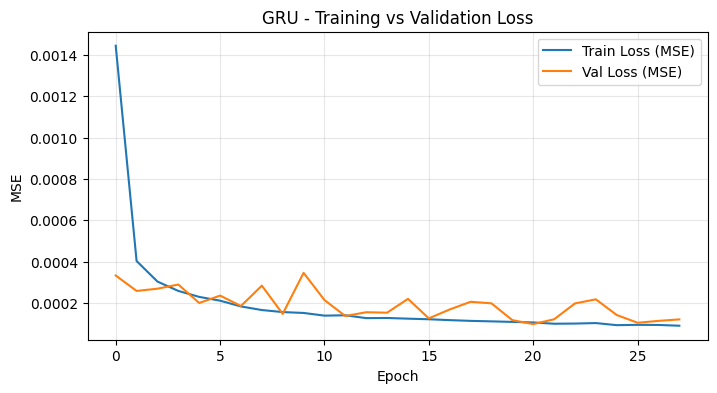

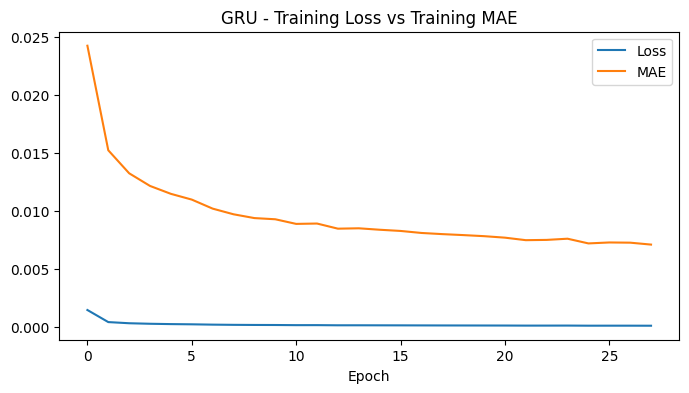

315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

 Overall Evaluation for ERCOT (Original Scale - MW)
MSE: 328965.2395260947
RMSE: 573.5549141329841
MAE: 413.22034562905344
MAPE: 0.7339370472970415 %


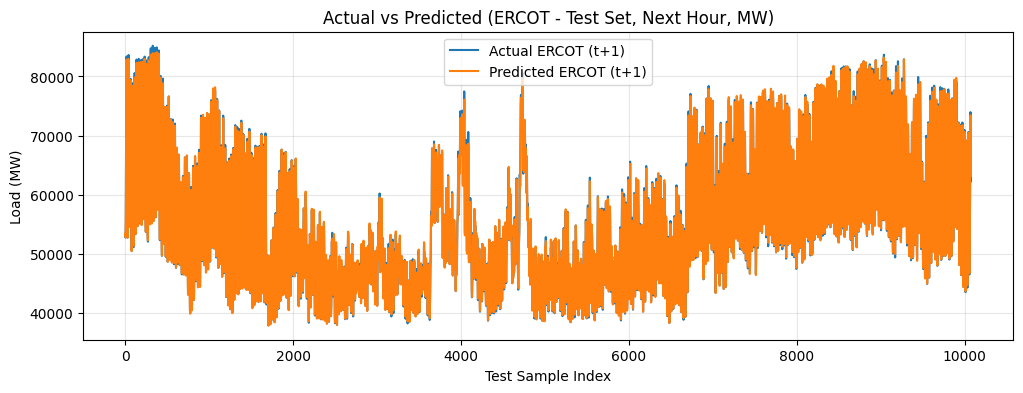

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


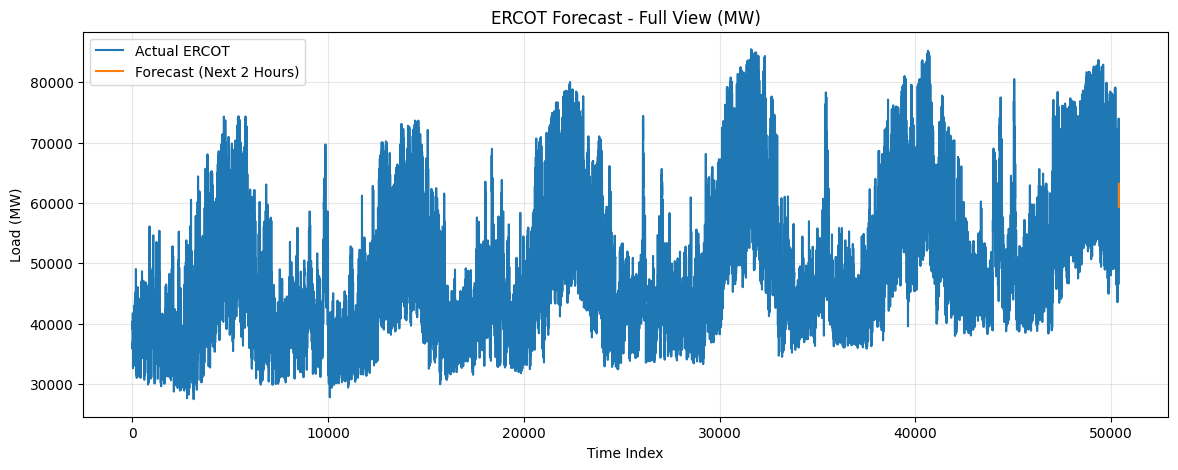

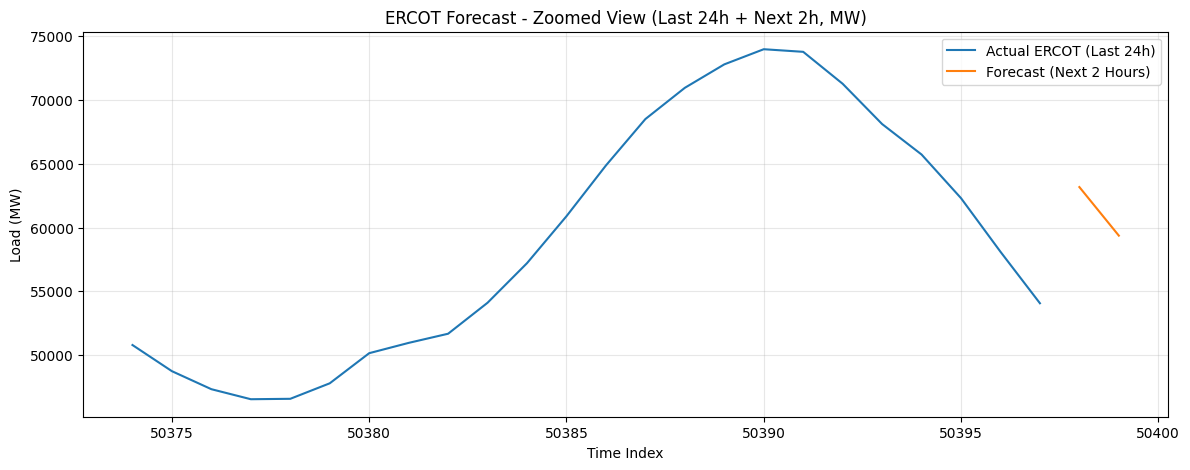

In [17]:
# GRU (Multiple features) - Evaluation
# ------------------------------------------------------------
# 8. Training Curves (train vs val)
# ------------------------------------------------------------

print("Training Loss:", history.history['loss'])
print("Training MAE:", history.history['mae'])

# Loss plot
pyplot.figure(figsize=(8,4))
pyplot.plot(history.history['loss'], label='Train Loss (MSE)')
pyplot.plot(history.history['val_loss'], label='Val Loss (MSE)')
pyplot.title('GRU - Training vs Validation Loss')
pyplot.xlabel('Epoch')
pyplot.ylabel('MSE')
pyplot.legend()
pyplot.grid(True, alpha=0.3)
pyplot.show()

# PLOT 1: Loss vs MAE
pyplot.figure(figsize=(8,4))
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['mae'])
pyplot.title('GRU - Training Loss vs Training MAE')
pyplot.xlabel('Epoch')
pyplot.legend(['Loss', 'MAE'], loc='upper right')
pyplot.show()

# ------------------------------------------------------------
# 9. Predict on Test Set
# ------------------------------------------------------------

y_pred = model.predict(X_test)    # shape: (n_test_samples, horizon)
y_true = y_test                   # shape: (n_test_samples, horizon)

# ------------------------------------------------------------
# 10. INVERSE SCALING for metrics (MW)
# ------------------------------------------------------------

# Flatten horizon dimension: (N*horizon, 1)
y_pred_scaled = y_pred.reshape(-1, 1)
y_true_scaled = y_true.reshape(-1, 1)

n_flat = y_pred_scaled.shape[0]

# Build full feature arrays for inverse_transform
pred_full_scaled = np.zeros((n_flat, num_features))
true_full_scaled = np.zeros((n_flat, num_features))

# Put ERCOT values into correct column
pred_full_scaled[:, ercot_idx] = y_pred_scaled[:, 0]
true_full_scaled[:, ercot_idx] = y_true_scaled[:, 0]

# Inverse transform to original scale
pred_full = scaler.inverse_transform(pred_full_scaled)
true_full = scaler.inverse_transform(true_full_scaled)

# Extract ERCOT column (in MW)
y_pred_inv = pred_full[:, ercot_idx]   # shape: (N*horizon,)
y_true_inv = true_full[:, ercot_idx]

# Metrics in MW
mse = mean_squared_error(y_true_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_inv, y_pred_inv)

eps = 1e-6  # to avoid divide-by-zero
mape = np.mean(np.abs((y_true_inv - y_pred_inv) / (y_true_inv + eps))) * 100

print("\n Overall Evaluation for ERCOT (Original Scale - MW)")
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape, "%")

# ------------------------------------------------------------
# 11. ERCOT Plot (t+1) in MW
# ------------------------------------------------------------

n_samples_test = y_true.shape[0]

# reshape back to (samples, horizon)
y_true_inv_seq = y_true_inv.reshape(n_samples_test, horizon)
y_pred_inv_seq = y_pred_inv.reshape(n_samples_test, horizon)

actual_test_ercot_t1 = y_true_inv_seq[:, 0]   # t+1
pred_test_ercot_t1   = y_pred_inv_seq[:, 0]

pyplot.figure(figsize=(12,4))
pyplot.plot(actual_test_ercot_t1, label='Actual ERCOT (t+1)')
pyplot.plot(pred_test_ercot_t1, label='Predicted ERCOT (t+1)')
pyplot.title("Actual vs Predicted (ERCOT - Test Set, Next Hour, MW)")
pyplot.xlabel("Test Sample Index")
pyplot.ylabel("Load (MW)")
pyplot.grid(True, alpha=0.3)
pyplot.legend()
pyplot.show()

# ------------------------------------------------------------
# 12. Forecasting Next 2 Hours for ERCOT (MW)
# ------------------------------------------------------------

last_window = X_test[-1].reshape(1, window, num_features)
future_pred_scaled = model.predict(last_window).reshape(horizon, 1)

# Build full feature vectors for inverse scaling
dummy_future_scaled = np.zeros((horizon, num_features))
dummy_future_scaled[:, ercot_idx] = future_pred_scaled[:, 0]

future_full = scaler.inverse_transform(dummy_future_scaled)
future_pred_ercot = future_full[:, ercot_idx]  # ERCOT in MW for next 2 hours

# Actual ERCOT history (inverse-scaled)
ercot_scaled_all = scaled_df[['ercot']].values
dummy_all_scaled = np.zeros((ercot_scaled_all.shape[0], num_features))
dummy_all_scaled[:, ercot_idx] = ercot_scaled_all[:, 0]
ercot_full = scaler.inverse_transform(dummy_all_scaled)
actual_series_ercot = ercot_full[:, ercot_idx]

future_x = np.arange(len(actual_series_ercot), len(actual_series_ercot) + horizon)

# Full series + forecast
pyplot.figure(figsize=(14,5))
pyplot.title("ERCOT Forecast - Full View (MW)")
pyplot.plot(np.arange(len(actual_series_ercot)), actual_series_ercot, label="Actual ERCOT")
pyplot.plot(future_x, future_pred_ercot, label="Forecast (Next 2 Hours)")
pyplot.xlabel("Time Index")
pyplot.ylabel("Load (MW)")
pyplot.grid(True, alpha=0.3)
pyplot.legend()
pyplot.show()

# Zoomed (last 24h + next 2h)
zoom_window = 24
start = len(actual_series_ercot) - zoom_window

pyplot.figure(figsize=(14,5))
pyplot.title("ERCOT Forecast - Zoomed View (Last 24h + Next 2h, MW)")
pyplot.plot(np.arange(start, len(actual_series_ercot)),
            actual_series_ercot[start:], label="Actual ERCOT (Last 24h)")
pyplot.plot(future_x, future_pred_ercot, label="Forecast (Next 2 Hours)")
pyplot.xlabel("Time Index")
pyplot.ylabel("Load (MW)")
pyplot.grid(True, alpha=0.3)
pyplot.legend()
pyplot.show()